# Note:
- This notebook takes files from the prior notebook and imputes NaNs using GMM and KNN to average imputed values from each imputation for all NaN fields.
    - Gaussian Mixture Model (GMM): This probabilistic model assumes that the data is generated from a mixture of several Gaussian distributions.
    - K-Nearest Neighbors (KNN): This method imputes missing values based on the values of the nearest neighbors.
        - We can achieve a more robust imputation for all NaN fields by averaging the imputed values from both methods.
    - Normalizing Features
        - Transform multiple features to ensure that they have similar scales. This step is crucial for many machine learning algorithms that are sensitive to the scale of the data.
- Output two heart transplant datasets with updated housekeeping pkl files. 
  - `5Heart_ML_Orig.pkl & 5Heart_ML_Impute.plk`
- Remove all Labels except `TransplantSurvivalDay` & `LengthOfStay` 

In [1]:
# path to user functions
import sys  
sys.path.append('../Src/')

from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib 

# import user functions
import UserUtilityFunctions as uf
import UserStatisticalFunctions as usf
import UserVisualization as uv
import UserImputeFunctions as ui

# set seaborn theme
sns.set_theme()

# initializing variables
REMOVE = '** REMOVE ** 5 Impute & Prep'
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### Import Data

In [2]:
# import data
df = pd.read_pickle("../Data/4CleanFull_Heart_Engineer.pkl")
df_label = pd.read_pickle("../Data/4CleanFull_Label_Engineer.pkl")
df_can = pd.read_pickle("../Data/4CleanFull_CAN_Engineer.pkl")
df_don = pd.read_pickle("../Data/4CleanFull_DON_Engineer.pkl")
df_both = pd.read_pickle("../Data/4CleanFull_BOTH_Engineer.pkl")
df_nominal = pd.read_pickle("../Data/4CleanFull_Nominal_Engineer.pkl")
df_ordinal = pd.read_pickle("../Data/4CleanFull_Ordinal_Engineer.pkl")
df_numeric = pd.read_pickle("../Data/4CleanFull_Numeric_Engineer.pkl")
df_new = pd.read_pickle("../Data/4CleanFull_New_Engineer.pkl")
df_drop = pd.read_pickle("../Data/4CleanFull_Drop_Engineer.pkl")
df_dict = pd.read_pickle("../Data/4CleanFull_Dictionary_Engineer.pkl")
df_object = pd.read_pickle("../Data/4CleanFull_Object_Engineer.pkl")
df_unknown = pd.read_pickle("../Data/4CleanFull_Unknown_Engineer.pkl")
df_date = pd.read_pickle("../Data/4CleanFull_Date_Engineer.pkl")

print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")
print(f"Label Features: {df_label.shape[0]:,}")
print(f"Candidate Features: {df_can.shape[0]:,}")
print(f"Donor Features: {df_don.shape[0]:,}")
print(f"Both Features: {df_both.shape[0]:,}")
print(f"Nominal Features: {df_nominal.shape[0]:,}")
print(f"Ordinal Features: {df_ordinal.shape[0]:,}")
print(f"Numeric Features: {df_numeric.shape[0]:,}")
print(f"New Features: {df_new.shape[0]:,}")
print(f"Drop Features: {df_drop.shape[0]:,}")
print(f"Dictionary Features: {df_object.shape[0]:,}")
print(f"Object Features: {df_object.shape[0]:,}")
print(f"Unknown Features: {df_unknown.shape[0]:,}")
print(f"Date Features: {df_date.shape[0]:,}")
# checking for duplicated column name
print(f"\nCheck for Duplicates in the DataFrame: {df.columns[df.columns.duplicated()]}")

Heart Dataset Rows: 27,494 & Columns: 237
Label Features: 15
Candidate Features: 119
Donor Features: 89
Both Features: 15
Nominal Features: 177
Ordinal Features: 12
Numeric Features: 49
New Features: 9
Drop Features: 26
Dictionary Features: 0
Object Features: 0
Unknown Features: 0
Date Features: 0

Check for Duplicates in the DataFrame: Index([], dtype='object')


### Remove Unwanted Label Features

In [3]:
# remove unwanted labels
removeCols = df_label.column[~df_label.column.isin(['TransplantSurvivalDay', 'LengthOfStay'])].to_list()

# remove features
df, df_dict, df_label, df_can, df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date = uf.house_keeping(df, removeCols, df_dict, df_label, df_can,\
                                                                df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date, txt=REMOVE, display=True)

Data Dictionary Updated.
Remove 13 row(s) from df_label DataFrame.
Remove 0 row(s) from df_can DataFrame.
Remove 0 row(s) from df_don DataFrame.
Remove 0 row(s) from df_both DataFrame.
Remove 1 row(s) from df_ordinal DataFrame.
Remove 10 row(s) from df_nominal DataFrame.
Remove 2 row(s) from df_numeric DataFrame.
Remove 0 row(s) from df_drop DataFrame.
Remove 0 row(s) from df_object DataFrame.
Remove 0 row(s) from df_unknown DataFrame.
Remove 0 row(s) from df_date DataFrame.

Removed Features: ['AcuteRejectionEpisode', 'AirwayDehiscencePostTransplant', 'DialysisPostDischarge', 'FunctionalStatusFollowUp', 'GraftFailStatus', 'GraftLifeSpanDay', 'GraftStatus', 'LastFollowupNumber', 'PacemakerPostTransplant', 'RecipientStatus', 'RejectionTreatmentWithinOneYear', 'StrokePostTransplant', 'TransplantStatus']

Total Row(s) & Column(s) Before Removing Column(s): 27,494 & columns: 237
Total Row(s) & Column(s) After Removing Column(s): 27,494 & columns: 224


### Candidate Survival Information

In [4]:
# total NaNs
print("Total NaNs for TransplantSurvivalDay: ", df.TransplantSurvivalDay.isna().sum())
print("Total NaNs for LengthOfStay: ", df.LengthOfStay.isna().sum())
# print
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")

Total NaNs for TransplantSurvivalDay:  425
Total NaNs for LengthOfStay:  887
Heart Dataset Rows: 27,494 & Columns: 224


In [5]:
# labels
pd.DataFrame(df[['TransplantSurvivalDay','LengthOfStay']].describe()).T

,count,mean,std,min,25%,50%,75%,max
TransplantSurvivalDay,27069.0,1274.198012,1020.204697,0.0,364.0,1093.0,2058.0,3861.0
LengthOfStay,26607.0,22.548878,25.934613,0.0,11.0,16.0,24.0,823.0


In [6]:
# sanity check
uf.datatypeDF(df, display=True)

Total Data feature count:  224

Boolean feature count: 0
Category feature count: 76
Numeric feature count: 47
Object feature count: 101
Other feature count: 0

Total feature count:  224


### Copy DataFrame

In [7]:
# copy dataframe
df_impute = df.copy()
# print shape
print(f"Orginal Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")
print(f"Impute Heart Dataset Rows: {df_impute.shape[0]:,} & Columns: {df_impute.shape[1]:,}")

Orginal Heart Dataset Rows: 27,494 & Columns: 224
Impute Heart Dataset Rows: 27,494 & Columns: 224


### Numeric Features

In [8]:
# only numerical features
numericCols = df_numeric.column.to_list()

# remove label
numericCols.remove('TransplantSurvivalDay')

# display
df_impute[numericCols].head()

,Age_DON,Age_CAN,Age_Listing_CAN,BMI_CAN,BMI_DON,BloodUreaNitrogenLevel_DON,WeightKg_DON,WeightKg_CAN,HeightCm_CAN,HeightCm_DON,Creatinine_DON,CreatinineTransplant_CAN,CreatinineRegistration_CAN,HemodynamicsRegistration_CO_CAN,HemodynamicsTransplant_CO_CAN,HemodynamicsRegistration_PA_DIA_CAN,HemodynamicsTransplant_PA_DIA_CAN,HemodynamicsRegistration_PA_MN_CAN,HemodynamicsTransplant_PA_MN_CAN,HemodynamicsRegistration_PCW_CAN,HemodynamicsTransplant_PCW_CAN,HemodynamicsRegistration_SYS_CAN,HemodynamicsTransplant_SYS_CAN,TotalDayWaitList_CAN,TotalBilirubinTransplant_CAN,TerminalTotalBilirubin_DON,OrganRecovery_PCO2_DON,Level_SGOT_AST_DON,Level_SGOT_ALT_DON,DistanceFromDonorHospitaltoTXCenter,LengthOfStay,Hematocrit_DON,IschemicTimeHour_DON,BloodPH_DON,LV_EjectionFractionPercent_DON,LungPO2_DON,LungPO2_FIO2_DON,Age_Addition,Age_Mean_CAN,HeightCm_Addition,WeightKg_Addition,BMI_Addition,Creatinine_Addition,Hemodynamics_Addition_CAN,Level_SGOT_Addition_DON,TotalBilirubin_Addition
0,31.0,45,45,22.061814,35.875594,18.0,107.0,65.8,172.7,172.7,1.30,1.00,1.3,2.50,NaN,34.0,NaN,37.0,NaN,36.0,NaN,50.0,NaN,11,3.6,0.4,40.0,46.0,40.0,83.0,76.0,26.2,4.9,7.38,60.0,182.0,47.0,121.0,45.0,345.4,172.8,57.937408,3.60,NaN,86.0,4.0
1,30.0,36,35,21.121131,22.497686,29.0,67.1,72.6,185.4,172.7,0.70,0.70,2.3,2.10,4.60,39.0,8.0,46.0,18.0,31.0,4.0,53.0,28.0,348,0.9,0.8,28.0,38.0,171.0,0.0,10.0,27.8,3.1,7.50,55.0,323.0,100.0,101.0,35.5,358.1,139.7,43.618816,3.70,233.7,209.0,1.7
2,15.0,58,58,34.493879,20.415225,15.0,59.0,106.0,175.3,170.0,0.74,2.19,1.4,5.00,4.40,23.0,21.0,32.0,22.0,NaN,13.0,52.0,28.0,55,1.2,0.7,41.0,445.0,217.0,0.0,21.0,25.4,1.4,7.40,60.0,401.0,100.0,131.0,58.0,345.3,165.0,54.909104,4.33,NaN,662.0,1.9
3,47.0,66,65,35.222825,43.358802,29.0,115.2,111.6,178.0,163.0,1.34,1.35,1.1,NaN,4.80,NaN,12.0,NaN,22.0,NaN,12.0,NaN,34.0,392,0.7,0.3,36.0,248.0,165.0,252.0,32.0,38.3,3.5,7.37,60.0,267.0,100.0,178.0,65.5,341.0,226.8,78.581627,3.79,NaN,413.0,1.0
4,22.0,70,70,24.337480,33.779330,70.0,113.0,72.0,172.0,182.9,5.10,0.80,0.8,4.75,4.75,15.0,15.0,20.0,20.0,15.0,15.0,30.0,30.0,42,0.8,0.5,33.0,137.0,174.0,60.0,26.0,30.7,2.8,7.51,55.0,209.0,100.0,162.0,70.0,354.9,185.0,58.116810,6.70,169.5,311.0,1.3


In [9]:
print(sorted(numericCols))

['Age_Addition', 'Age_CAN', 'Age_DON', 'Age_Listing_CAN', 'Age_Mean_CAN', 'BMI_Addition', 'BMI_CAN', 'BMI_DON', 'BloodPH_DON', 'BloodUreaNitrogenLevel_DON', 'CreatinineRegistration_CAN', 'CreatinineTransplant_CAN', 'Creatinine_Addition', 'Creatinine_DON', 'DistanceFromDonorHospitaltoTXCenter', 'HeightCm_Addition', 'HeightCm_CAN', 'HeightCm_DON', 'Hematocrit_DON', 'HemodynamicsRegistration_CO_CAN', 'HemodynamicsRegistration_PA_DIA_CAN', 'HemodynamicsRegistration_PA_MN_CAN', 'HemodynamicsRegistration_PCW_CAN', 'HemodynamicsRegistration_SYS_CAN', 'HemodynamicsTransplant_CO_CAN', 'HemodynamicsTransplant_PA_DIA_CAN', 'HemodynamicsTransplant_PA_MN_CAN', 'HemodynamicsTransplant_PCW_CAN', 'HemodynamicsTransplant_SYS_CAN', 'Hemodynamics_Addition_CAN', 'IschemicTimeHour_DON', 'LV_EjectionFractionPercent_DON', 'LengthOfStay', 'Level_SGOT_ALT_DON', 'Level_SGOT_AST_DON', 'Level_SGOT_Addition_DON', 'LungPO2_DON', 'LungPO2_FIO2_DON', 'OrganRecovery_PCO2_DON', 'TerminalTotalBilirubin_DON', 'TotalBilir

#### Data Dictionary

In [10]:
df_dict[df_dict.Feature.isin(numericCols)]

,Feature,Description,Form,FeatureStartDate,FeatureEndDate,FormSection,DataType,SASAnalysisFormat,Comment,OrginalFeature,FeatureType,Information
7,Age_CAN,RECIPIENT AGE (YRS),TRR-CALCULATED,1987-10-01,NaT,RECIPIENT INFORMATION,NUM,,,AGE,Numeric,
8,Age_DON,DONOR AGE (YRS),DDR/LDR-CALCULATED,1987-10-01,NaT,DONOR INFORMATION,NUM,,,AGE_DON,Numeric,
16,BMI_DON,Donor BMI - Pre/At Donation Calculated,CALCULATED,NaT,NaT,,NUM,,,BMI_DON_CALC,Numeric,
21,BloodUreaNitrogenLevel_DON,DECEASED DONOR-TERMINAL BLOOD UREA NITROGEN,DDR,1994-04-01,NaT,CLINICAL INFORMATION,NUM,,,BUN_DON,Numeric,
45,Creatinine_DON,DECEASED DONOR-TERMINAL LAB CREATININE,DDR,1994-04-01,NaT,CLINICAL INFORMATION,NUM,,,CREAT_DON,Numeric,
46,CreatinineTransplant_CAN,RECIPIENT SERUM CREATININE AT TIME OF TX,TRR,1994-04-01,NaT,PRETRANSPLANT CLINICAL INFORMATION,NUM,,,CREAT_TRR,Numeric,
62,TotalDayWaitList_CAN,TOTAL DAYS ON WAITING LIST,CALCULATED,NaT,NaT,,NUM,,,DAYSWAIT_CHRON,Numeric,
77,DistanceFromDonorHospitaltoTXCenter,DISTANCE FROM DONOR HOSP TO TX CENTER (Nautical Miles),CALCULATED,NaT,NaT,,NUM,,,DISTANCE,Numeric,** LABEL ** N/Y/U/X to No/Yes/Unknown/Missing
97,BMI_CAN,Calculated Candidate BMI at Removal/Current Time,CALCULATED,NaT,NaT,,NUM,,,END_BMI_CALC,Numeric,
99,HeightCm_CAN,Calculated Candidate Height in CM at Removal/Current Time,CALCULATED,NaT,NaT,,NUM,,,END_HGT_CM_CALC,Numeric,


### Disply NaNs

In [11]:
# display NaNs
NaNs = uf.percentage_null(df_impute)
# print
NaNs

,percentage,NaNCount
Hemodynamics_Addition_CAN,18.502219,5087
HemodynamicsRegistration_PCW_CAN,9.503892,2613
HemodynamicsTransplant_PCW_CAN,8.550957,2351
HemodynamicsRegistration_CO_CAN,5.772168,1587
HemodynamicsTransplant_CO_CAN,5.655779,1555
HemodynamicsTransplant_PA_MN_CAN,5.015640,1379
HemodynamicsRegistration_PA_MN_CAN,4.568269,1256
HemodynamicsTransplant_PA_DIA_CAN,4.142722,1139
HemodynamicsTransplant_SYS_CAN,4.084528,1123
HemodynamicsRegistration_PA_DIA_CAN,3.691715,1015


### Impute Numeric Features
##### `KNN Impute:` Impute missing values in datasets using the k-Nearest Neighbors algorithm. 
- It replaces missing values with estimates based on similar data points in the dataset.
- For each sample with missing values, it finds the k nearest neighbors in the dataset.
    - It then imputes the missing value using the mean or weighted average of those neighbors' values.
- Preserves the original variable distribution.
- Does not assume any underlying data distribution.
- Can handle complex relationships in the data.
- KNN Imputation is a flexible and effective method for handling missing data, particularly when the relationships between variables are complex or non-linear.

##### Gaussian Mixture Model (GMM)
- Gaussian Mixture Model (GMM) imputation is a probabilistic approach to handling missing data by leveraging the Gaussian Mixture Model to estimate missing values based on the distribution of observed data.
- The dataset is assumed to follow a mixture of multiple Gaussian distributions.
- The Expectation-Maximization (EM) algorithm is used to estimate the parameters (means, covariances, and weights) of the Gaussian components.
Classify Data Points into Components
- Each data point is assigned a probability of belonging to each Gaussian component.
    - Impute Missing Values
        - If a feature has missing values, the missing entries are estimated using conditional probabilities derived from the Gaussian distributions.
        - Given an incomplete data point, the missing values are estimated using the conditional expectation based on the component distributions.
            - Advantages:
                - Flexible modeling: Captures multimodal distributions better than simple mean or median imputation.
                - Probabilistic approach: Accounts for uncertainty in missing data.
                - Works well with continuous data.

##### Combining GMM and KNN Imputation if data in Normally distributed
- Combining Gaussian Mixture Model (GMM) and k-Nearest Neighbors (KNN) imputation methods can be a robust approach for handling data that is not Missing Completely At Random (MNAR).
    - For data that is MNAR, combining these two methods can leverage the strengths of both:
        - GMM Imputation: Use GMM to estimate the missing values based on the overall distribution of the data.
        - KNN Imputation: Apply KNN to refine these estimates by considering the local structure of the data.
        - Taking the mean of the imputed values from both methods can provide a balanced estimate that accounts for both global and local patterns in the data.

##### Note:
- `KNN` imputation estimates missing values by averaging or taking weighted averages of the nearest neighbors' corresponding features. This method does not inherently assume a specific distribution, making it flexible for various data types, including non-normally distributed data. However, its effectiveness relies on the assumption that the nearest neighbors are similar and that the missing data mechanism is random. KNN can be particularly useful when dealing with non-random missingness and can lead to more accurate and reliable machine-learning models.
- `GMM` imputation models the data as a mixture of several Gaussian distributions, which can be beneficial for capturing complex data structures. However, GMM assumes that the data within each component follows a normal distribution. When dealing with non-normally distributed data, this assumption may not hold, potentially leading to biased imputations.

#### Hemodynamics
- [CO (Cardiac Output)](https://www.ncbi.nlm.nih.gov/books/NBK470455/#:~:text=Cardiac%20output%20in%20humans%20is,to%20100%20times%20each%20minute.):
    - Definition: Similar to the registration phase, it measures the heart's output during the transplant phase.
    - Importance: Critical for ensuring adequate perfusion during surgery.
    - Cardiac output in humans is generally 5-6 L/min
- [PA_DIA (Pulmonary Artery Diastolic Pressure)](https://www.ncbi.nlm.nih.gov/books/NBK209987/):
    - Definition: Monitored to assess right heart function and pulmonary circulation during transplant.
- [PA_MN (Pulmonary Artery Mean Pressure)](https://www.ncbi.nlm.nih.gov/books/NBK209987/):
    - Definition: Helps in evaluating pulmonary hypertension and right ventricular function.
    - Severe pulmonary hypertension artery pressure of 40 mm Hg or greater
    - Moderate pulmonary hypertension artery pressure between 25 and 39 mm Hg
    - Normal pulmonary artery pressure between 11 and 25 mm Hg
- [PCW (Pulmonary Capillary Wedge Pressure)](https://pubmed.ncbi.nlm.nih.gov/24268673/):
    - Definition: Used to monitor left ventricular function and fluid status during transplant.
- [SYS (Systemic Arterial Pressure)](https://www.ncbi.nlm.nih.gov/books/NBK538509/):
    - Definition: Monitored to ensure stable blood pressure and perfusion during transplant.

In [12]:
features = uf.get_feature_list(df_impute, 'Hemodynamics')

                                       count        mean        std    min     25%     50%     75%    max
HemodynamicsRegistration_CO_CAN      25907.0    4.260398   1.340504   0.39    3.32    4.10    5.00   15.0
HemodynamicsRegistration_PA_DIA_CAN  26479.0   20.504332   8.689102   0.00   14.00   20.00   26.00   91.0
HemodynamicsRegistration_PA_MN_CAN   26238.0   28.598895  10.199296   0.00   21.00   28.00   36.00   96.0
HemodynamicsRegistration_PCW_CAN     24881.0   19.112114   8.805536   0.00   12.00   19.00   25.00   50.0
HemodynamicsRegistration_SYS_CAN     26498.0   41.967507  14.231162   0.00   31.00   41.00   52.00  130.0
HemodynamicsTransplant_CO_CAN        25939.0    4.531083   1.458923   0.20    3.50    4.39    5.34   15.0
HemodynamicsTransplant_PA_DIA_CAN    26355.0   19.166428   8.481572   0.00   13.00   18.00   25.00  110.0
HemodynamicsTransplant_PA_MN_CAN     26115.0   27.018696   9.911634   0.00   20.00   26.00   34.00  110.0
HemodynamicsTransplant_PCW_CAN       25143.0  

Little's MCAR test p-value: 0.0000
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


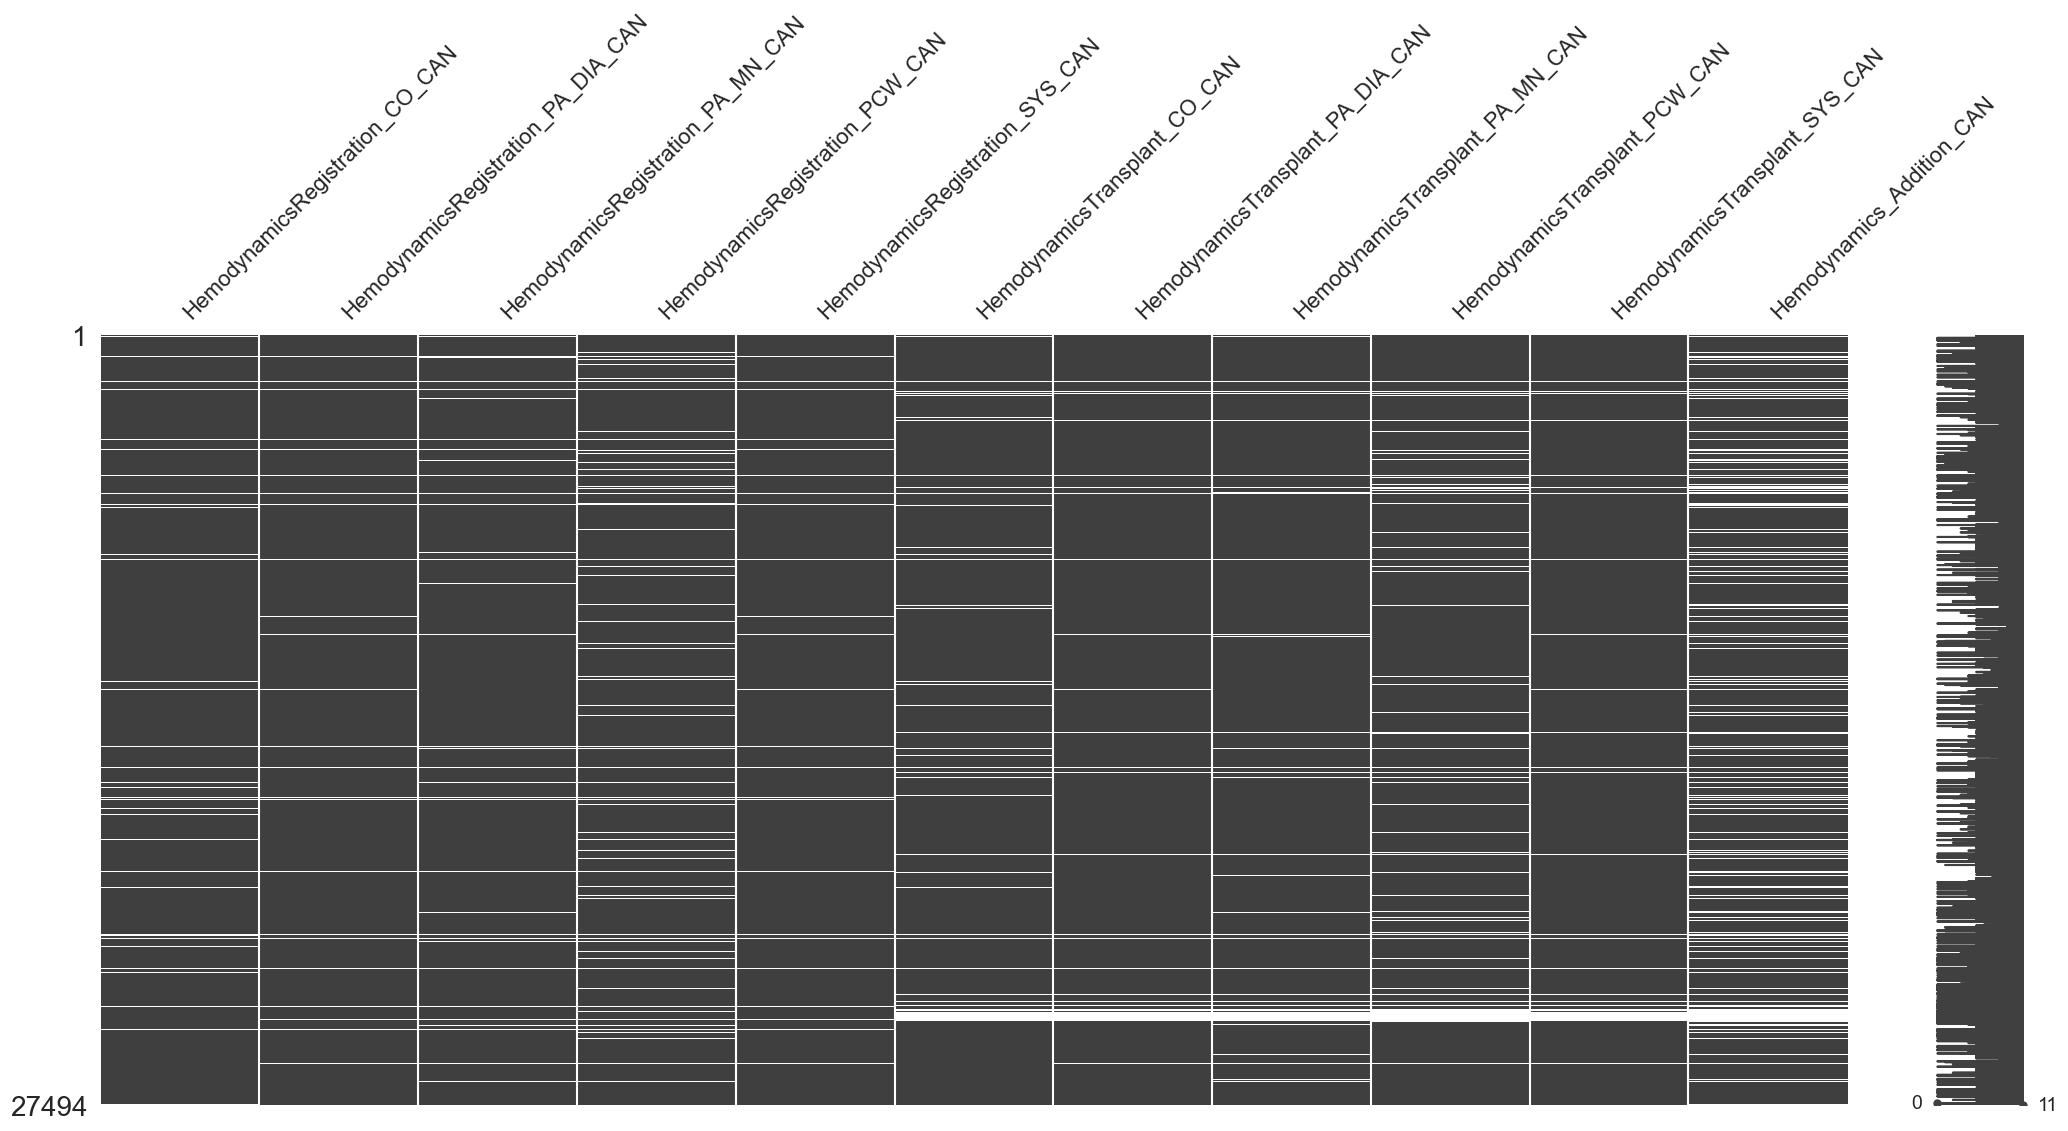

In [13]:
# stats test
usf.test_mcar(df_impute[features])
# plot missing data
uv.plot_missingness(df_impute[features])

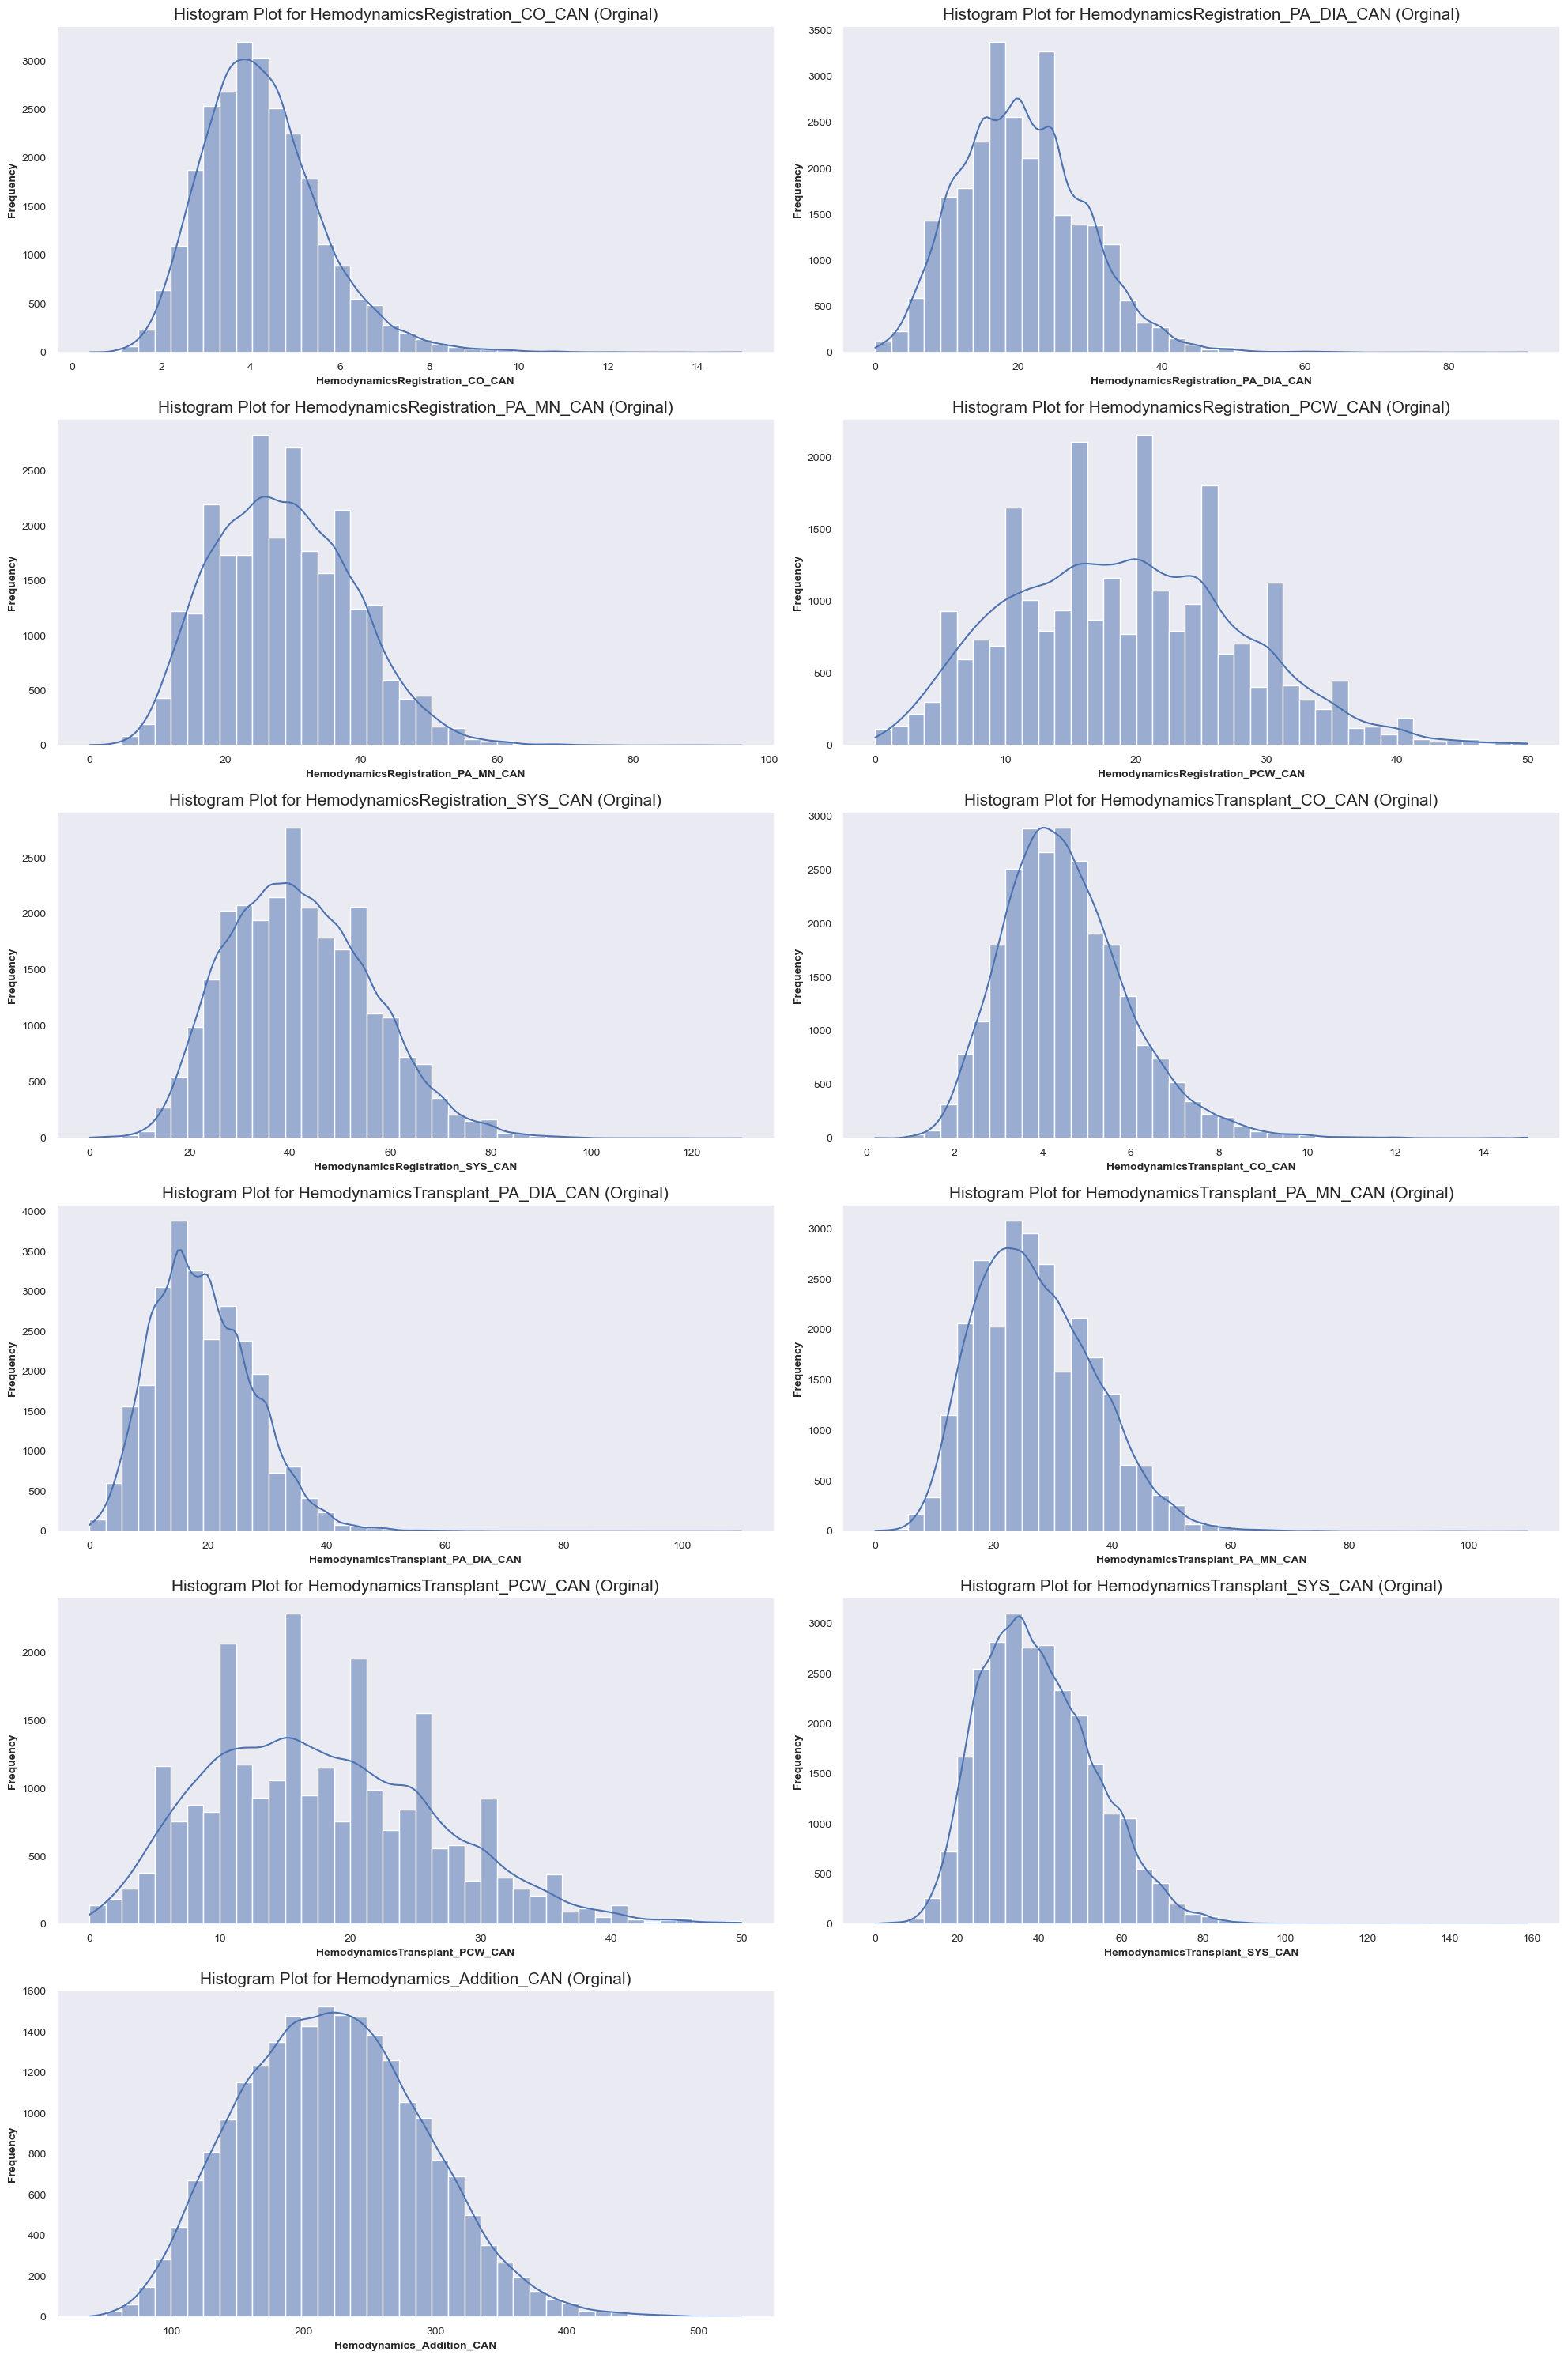

In [14]:
# plot
uv.plot_histogram(df_impute, features, txt= '(Orginal)', bins=40)

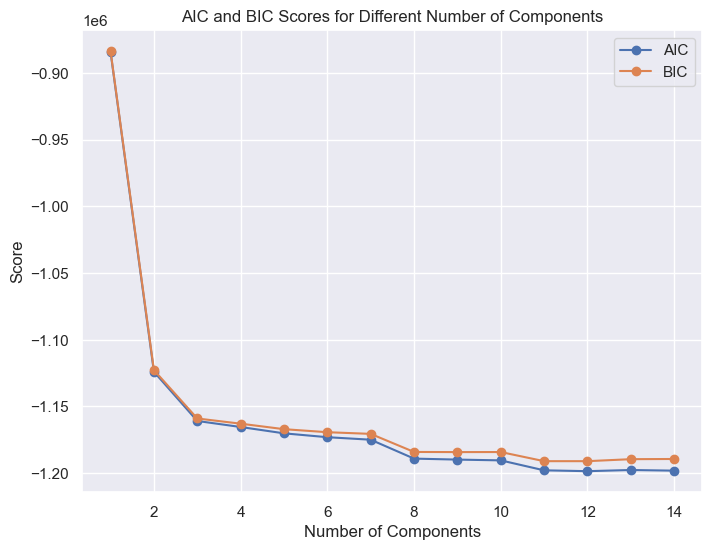

Optimal number of components: 12


In [15]:
# find components
ui.find_gaussian_mixture_components(df_impute[features], component_range=range(1, 15), seed=RANDOM_STATE)

In [16]:
# impute using GMM
imputeGMM = ui.impute_gaussian_mixture(df_impute[features], RANDOM_STATE, n_components=12)

The best n_neighbors for KNN imputer is: 5
The best weights for KNN imputer is: distance


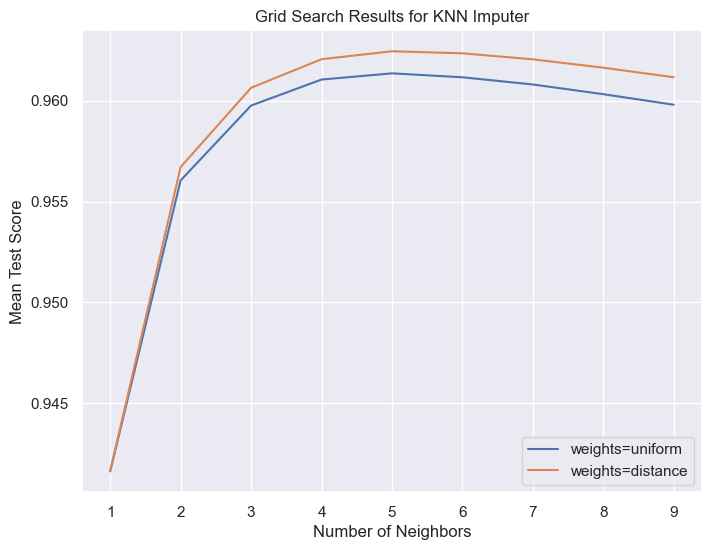

In [17]:
# impute knn
imputeKNN = ui.impute_knn(df_impute[features], n_neighbors=range(1, 10))

In [18]:
# calculate the average
imputeAverage = (imputeGMM + imputeKNN) / 2

# update imputed features
df_impute[features] = imputeAverage
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
HemodynamicsRegistration_CO_CAN,27494.0,4.264674,1.324236,0.39,3.360000,4.120000,5.000000,15.0
HemodynamicsRegistration_PA_DIA_CAN,27494.0,20.570842,8.622934,0.00,14.000000,20.000000,26.000000,91.0
HemodynamicsRegistration_PA_MN_CAN,27494.0,28.492246,10.086627,0.00,21.000000,28.000000,35.000000,96.0
HemodynamicsRegistration_PCW_CAN,27494.0,18.847406,8.515870,0.00,12.594095,18.000000,25.000000,50.0
HemodynamicsRegistration_SYS_CAN,27494.0,41.802011,14.122771,0.00,31.000000,41.000000,51.000000,130.0
HemodynamicsTransplant_CO_CAN,27494.0,4.528885,1.446229,0.20,3.520000,4.390000,5.330000,15.0
HemodynamicsTransplant_PA_DIA_CAN,27494.0,19.450998,8.605578,0.00,13.000000,19.000000,25.000000,110.0
HemodynamicsTransplant_PA_MN_CAN,27494.0,27.109430,9.860393,0.00,20.000000,26.000000,34.000000,110.0
HemodynamicsTransplant_PCW_CAN,27494.0,17.640214,8.411751,0.00,11.000000,17.000000,23.000000,50.0
HemodynamicsTransplant_SYS_CAN,27494.0,39.873555,13.782187,0.00,30.000000,38.000000,49.000000,159.0


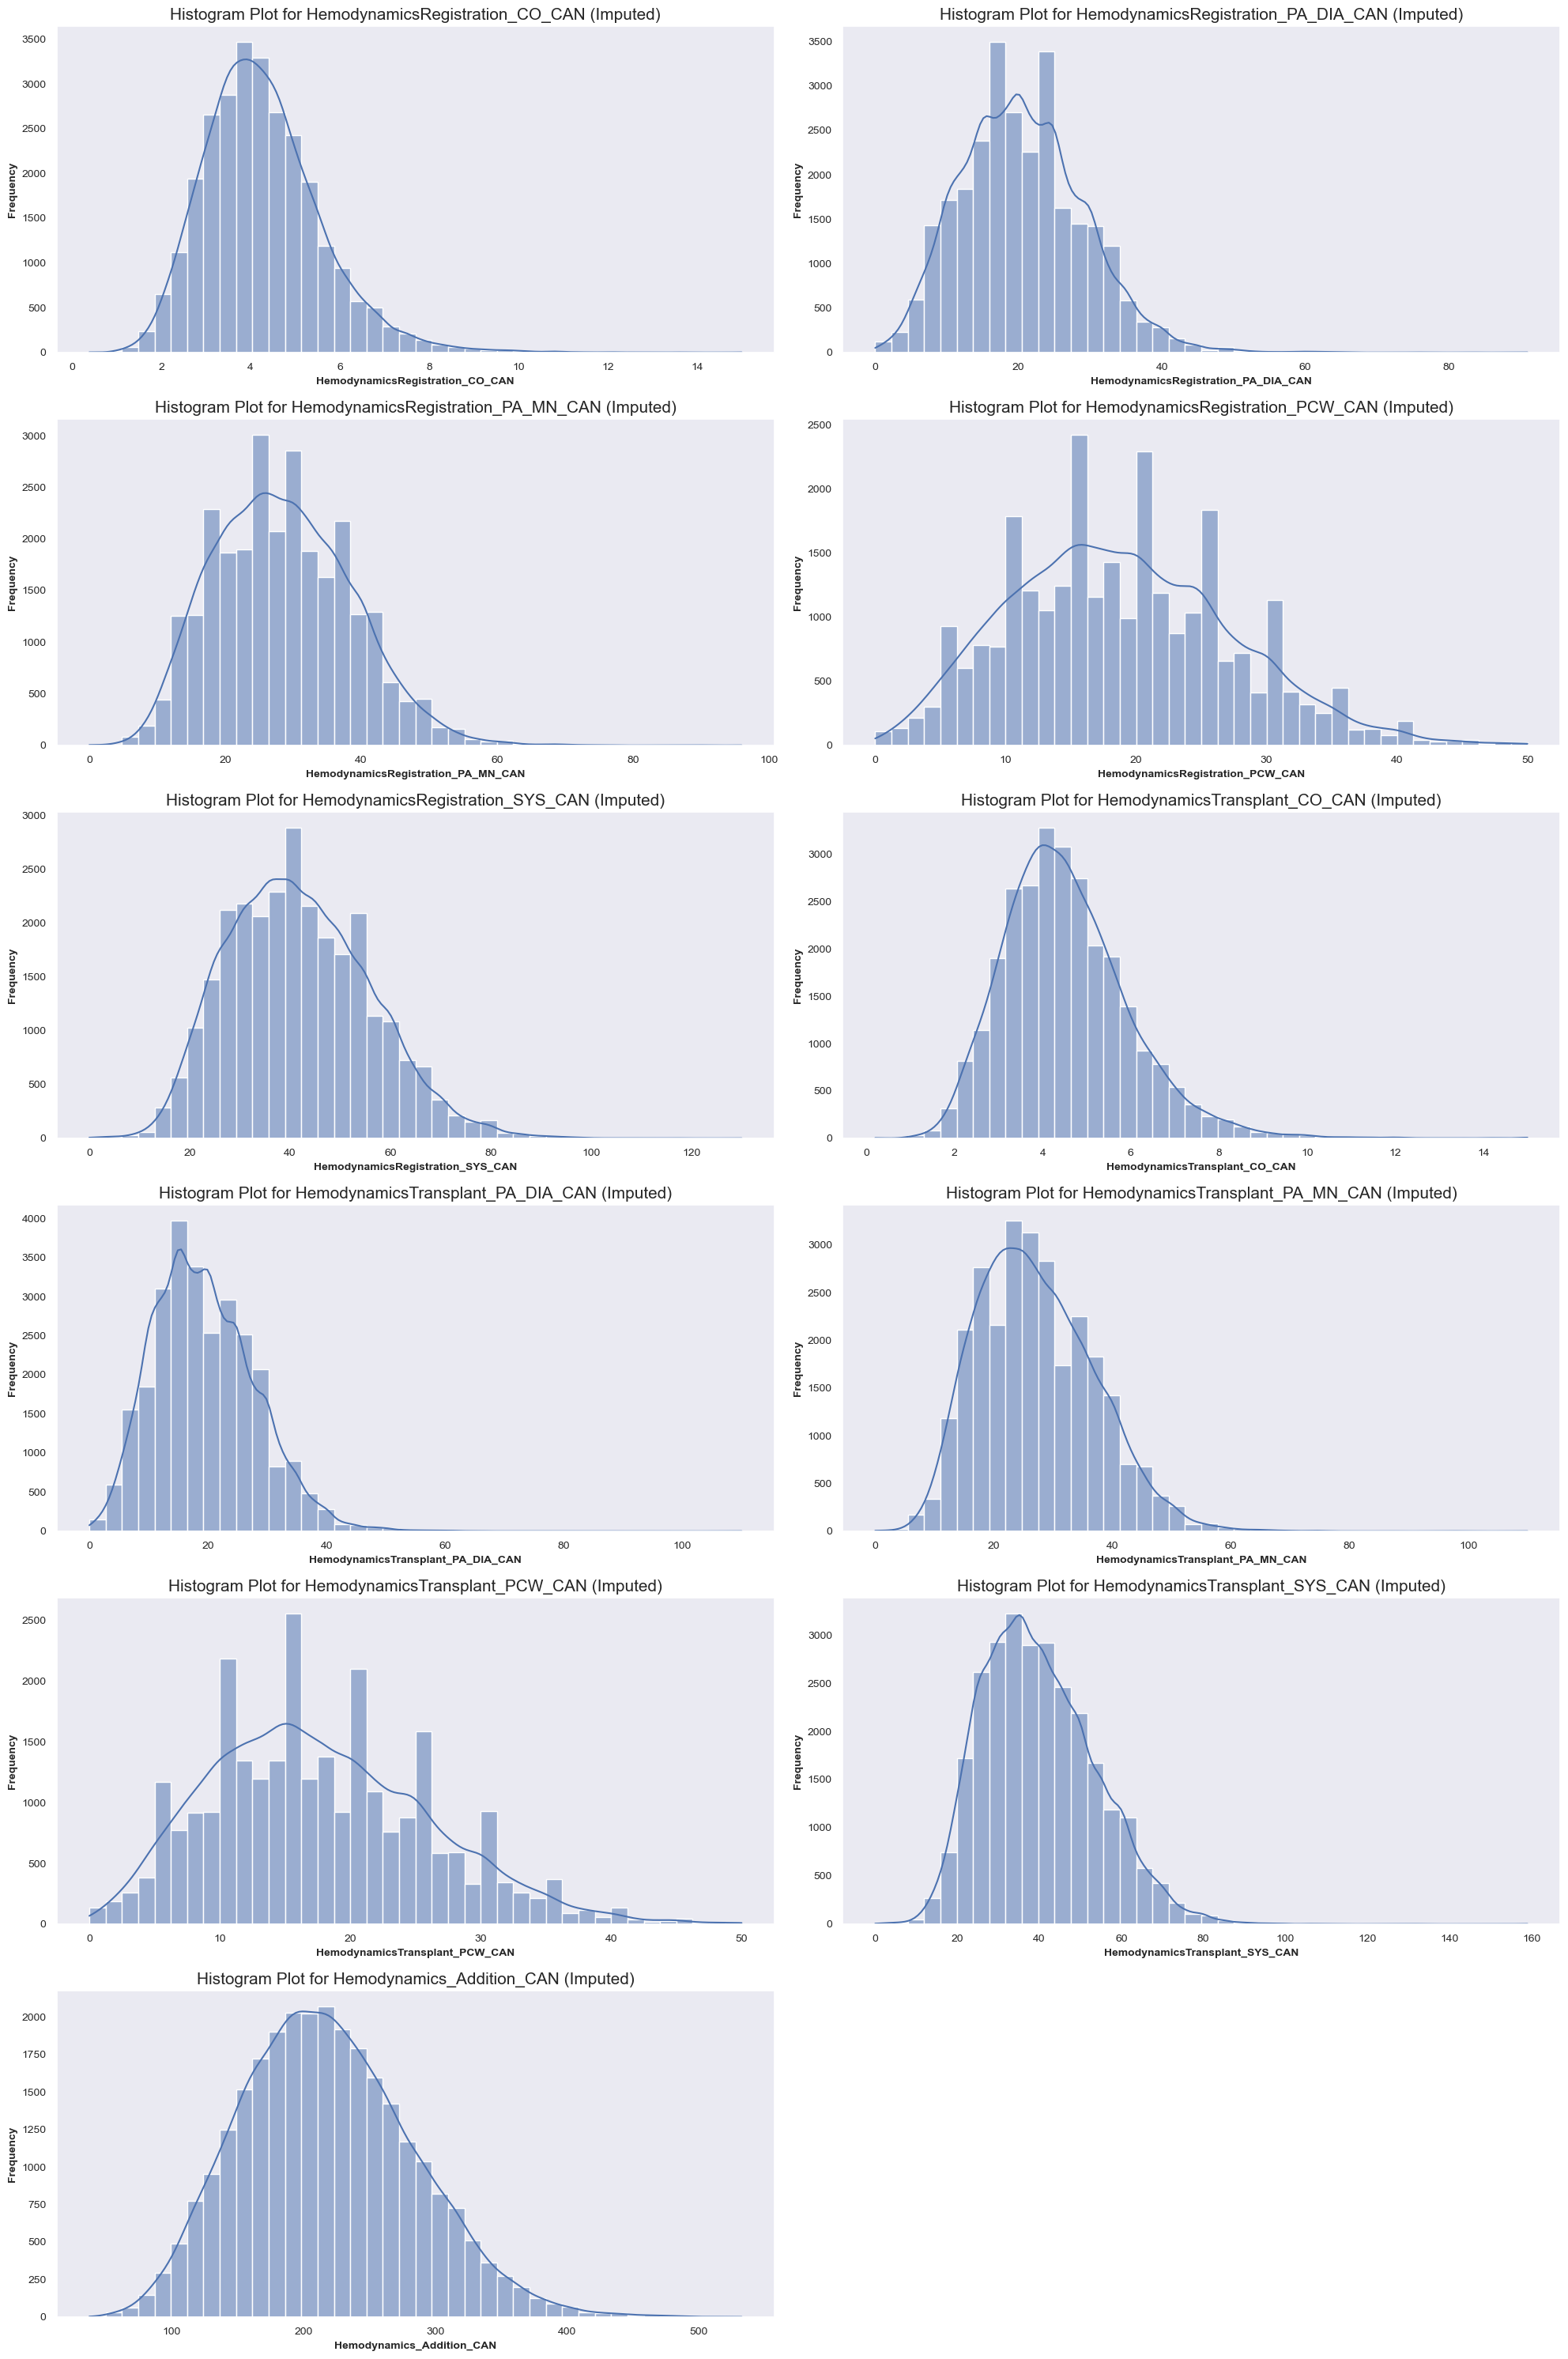

In [19]:
# plot
uv.plot_histogram(df_impute, features, txt= '(Imputed)', bins=40)

#### [IschemicTimeHour](https://www.jhltonline.org/article/S1053-2498(23)01819-3/fulltext)
-  The maximum time it can be without blood supply before significant damage occurs, is around 4 hours when preserved in cold storage for transplantation; exceeding this timeframe significantly increases the risk of complications and poor outcomes after transplant. 

In [20]:
features = uf.get_feature_list(df_impute, 'IschemicTimeHour')

                        count      mean       std  min  25%  50%  75%   max
IschemicTimeHour_DON  26941.0  3.234223  1.070724  0.3  2.5  3.3  3.9  12.0

:::: NaN Count:
IschemicTimeHour_DON    553


Little's MCAR test p-value: nan
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


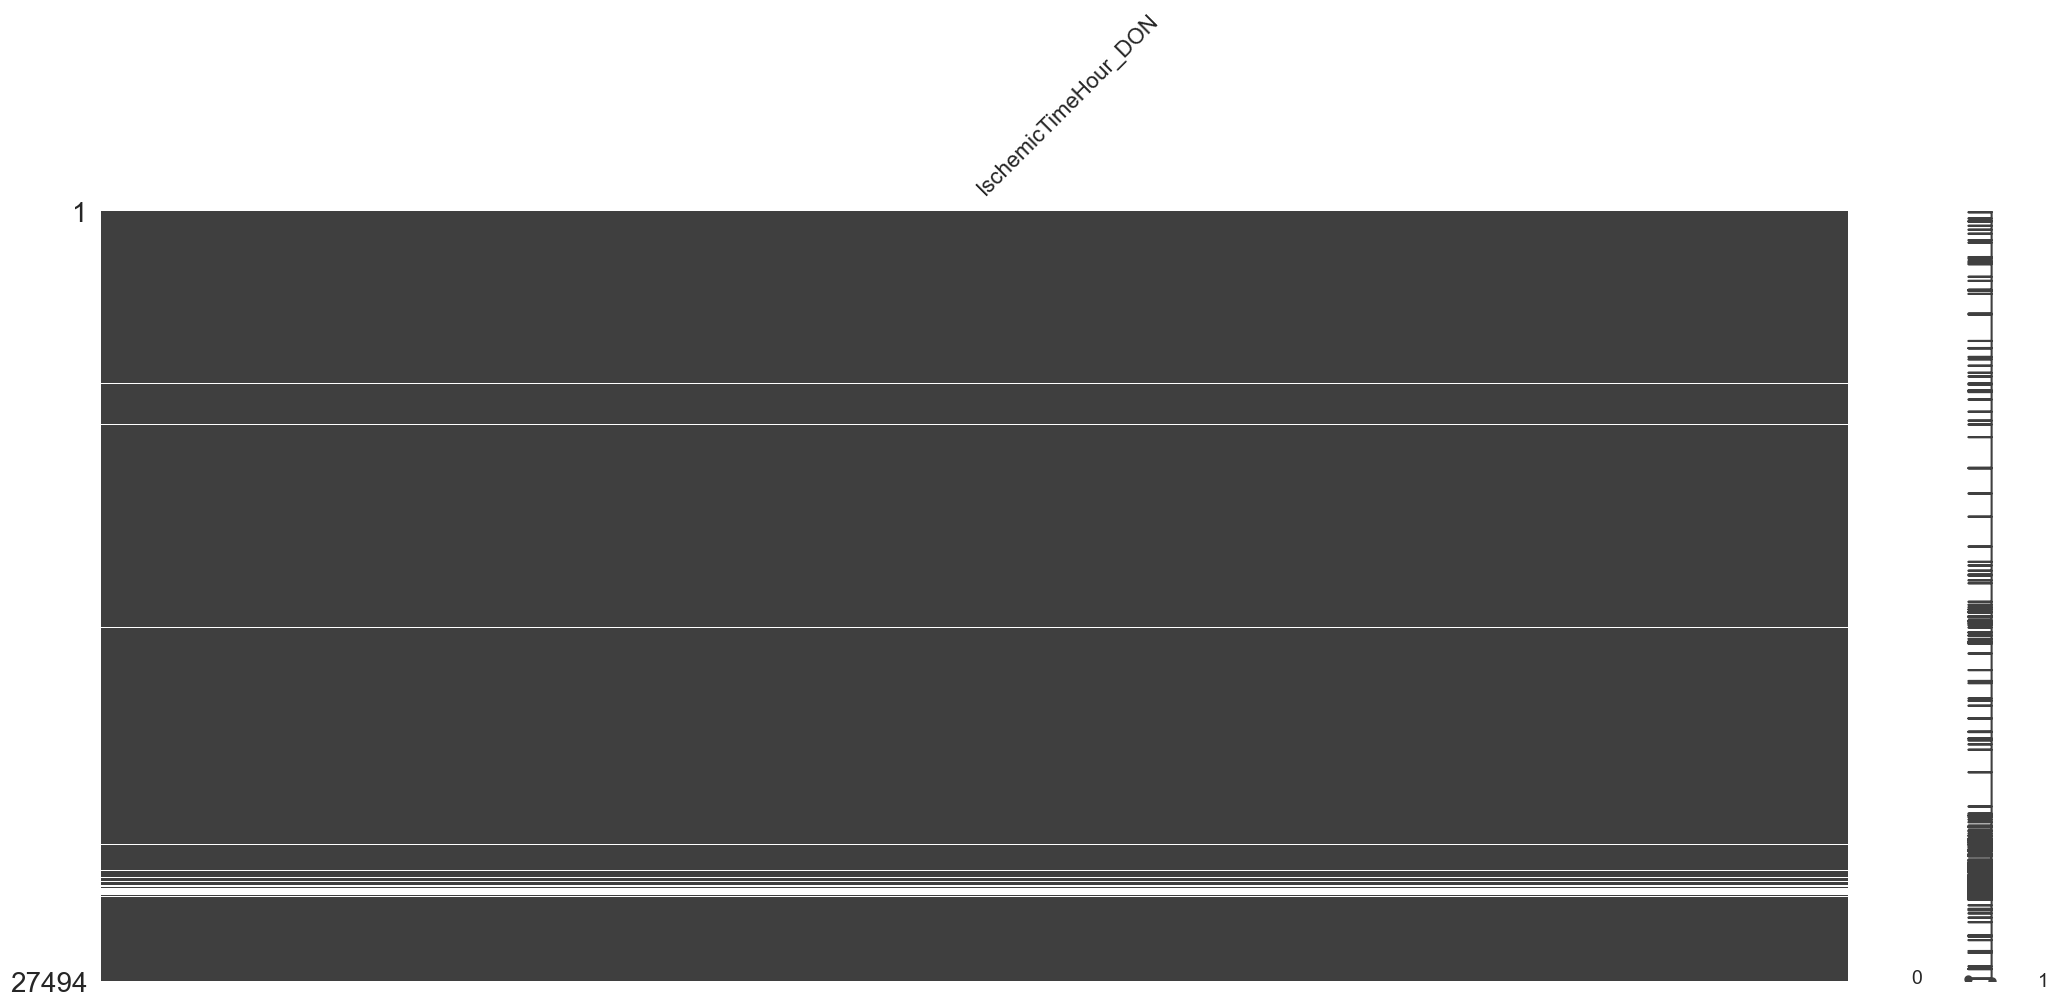

In [21]:
# stats test
usf.test_mcar(df_impute[features])
# plot missing data
uv.plot_missingness(df_impute[features])

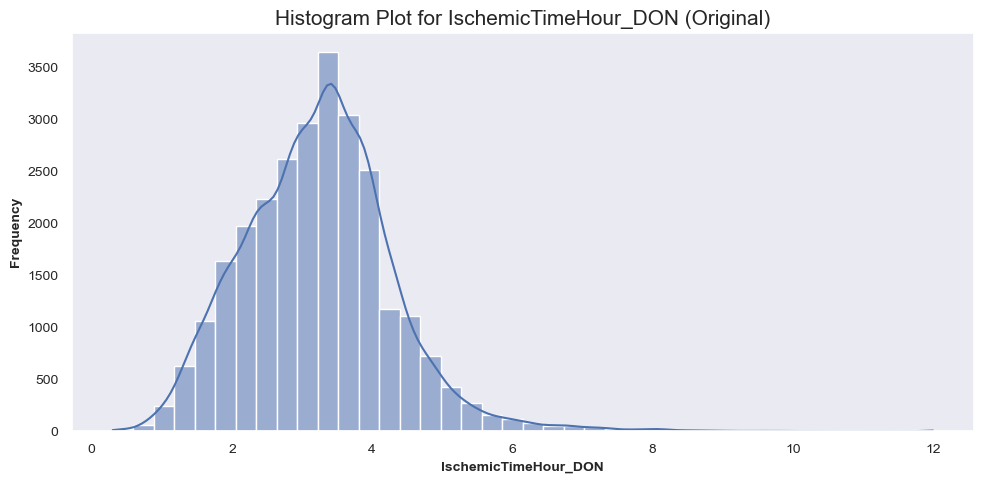

In [22]:
# plot
uv.plot_histogram(df_impute, features, txt='(Original)', bins=40)

In [23]:
# update median
df_impute[features] = df_impute[features].fillna(df_impute[features].median())
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
IschemicTimeHour_DON,27494.0,3.235546,1.059942,0.3,2.5,3.3,3.8,12.0


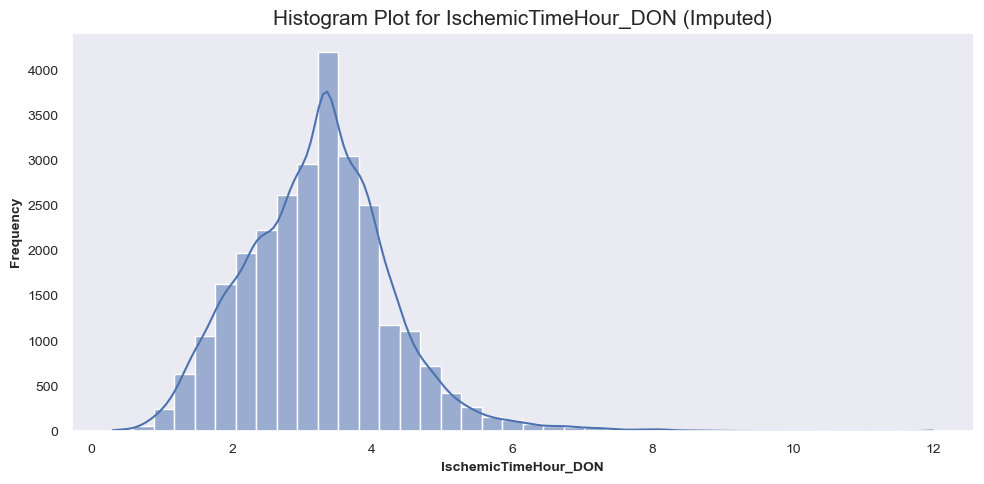

In [24]:
# plot
uv.plot_histogram(df_impute, features, txt= '(Imputed)', bins=40)

#### Lung PO2 (REMOVE)
- Lung PO2 (Partial Pressure of Oxygen) is a measure of the pressure exerted by oxygen in the lungs. It is an important indicator of how well oxygen is being transferred from the air in the lungs to the blood. The value of PO2 is typically measured in millimeters of mercury (mmHg) and provides insight into the efficiency of the respiratory system. In clinical and transplant contexts, particularly with donors, it helps assess the oxygenation status of the donor’s lungs, which is critical when evaluating organs for transplantation. `LungPO2_DON`: PO2 on 100% oxygen refers to the partial pressure of oxygen in arterial blood when a patient is breathing 100% oxygen.

- The Fraction of Inspired Oxygen (Lung FIO2) refers to the concentration of oxygen in the air that is being inhaled by a patient. It is a critical parameter in managing patients with respiratory distress and is often expressed as a percentage or as a decimal. `LungPO2_FIO2_DON`: Lung pO2 on FiO2 refers to the partial pressure of oxygen in arterial blood (PaO2) in relation to the fraction of inspired oxygen (FiO2).
    - Normal Range for FIO2
        - Room Air: The FIO2 in room air is approximately 21% or 0.21 as a decimal.
    - Supplemental Oxygen:
        - Low-Flow Oxygen Therapy: FIO2 can range from about 24% (0.24) to 40% (0.40), depending on the delivery device (e.g., nasal cannula, simple face mask).
        - High-Flow Oxygen Therapy: FIO2 can be set between 40% (0.40) and 100% (1.0), especially in more controlled environments like intensive care units.<br>

In [25]:
features = uf.get_feature_list(df_impute, 'LungPO2')

                    count unique      top   freq        mean         std   min    25%    50%    75%    max
LungPO2_DON       27254.0    NaN      NaN    NaN  281.117169  159.796818  7.38  131.0  258.0  426.0  698.0
LungPO2_Done_DON    27494      3  Unknown  19938         NaN         NaN   NaN    NaN    NaN    NaN    NaN
LungPO2_FIO2_DON  27175.0    NaN      NaN    NaN   82.080221   25.587828   1.0   60.0  100.0  100.0  100.0

:::: NaN Count:
LungPO2_DON         240
LungPO2_Done_DON      0
LungPO2_FIO2_DON    319


In [26]:
# add to removeCols list
removeCols = features

#### Bilirubin (Transform)
- Bilirubin levels can be an important factor in heart transplantation, particularly in the context of post-operative outcomes. Elevated bilirubin levels, or hyperbilirubinemia, can indicate liver dysfunction, which is a common complication following cardiac surgery, including heart transplantation.
    - Prognostic Marker: Hyperbilirubinemia is often used as a prognostic marker for adverse outcomes after cardiac surgery. Elevated bilirubin levels are associated with increased in-hospital mortality, prolonged ICU stays, and other complications.
    - Incidence and Risk Factors: The incidence of hyperbilirubinemia after cardiac surgery varies widely, with reports ranging from 8.6% to 40%. Risk factors include the type of surgery, duration of cardiopulmonary bypass, and pre-existing liver conditions.
    - Management: Managing elevated bilirubin levels involves addressing the underlying causes, such as improving liver perfusion and reducing hemolysis. Treatments like bilirubin adsorption and plasma exchange have been studied for their efficacy in reducing bilirubin levels and improving outcomes.
    - Impact on Transplant Outcomes: High bilirubin levels can complicate the post-operative course and affect the overall success of the heart transplant. Monitoring and managing bilirubin levels is crucial for improving patient outcomes. 

In [27]:
features = uf.get_feature_list(df_impute, 'Bilirubin.*CAN|TotalBilirubin.*DON')

                                count      mean       std  min  25%  50%  75%   max
TerminalTotalBilirubin_DON    27288.0  1.044261  1.427990  0.0  0.5  0.7  1.1  45.4
TotalBilirubinTransplant_CAN  27041.0  0.995037  1.732819  0.1  0.5  0.7  1.1  80.0

:::: NaN Count:
TerminalTotalBilirubin_DON      206
TotalBilirubinTransplant_CAN    453


In [28]:
df_impute[features].corr()

,TerminalTotalBilirubin_DON,TotalBilirubinTransplant_CAN
TerminalTotalBilirubin_DON,1.00000,0.00412
TotalBilirubinTransplant_CAN,0.00412,1.00000


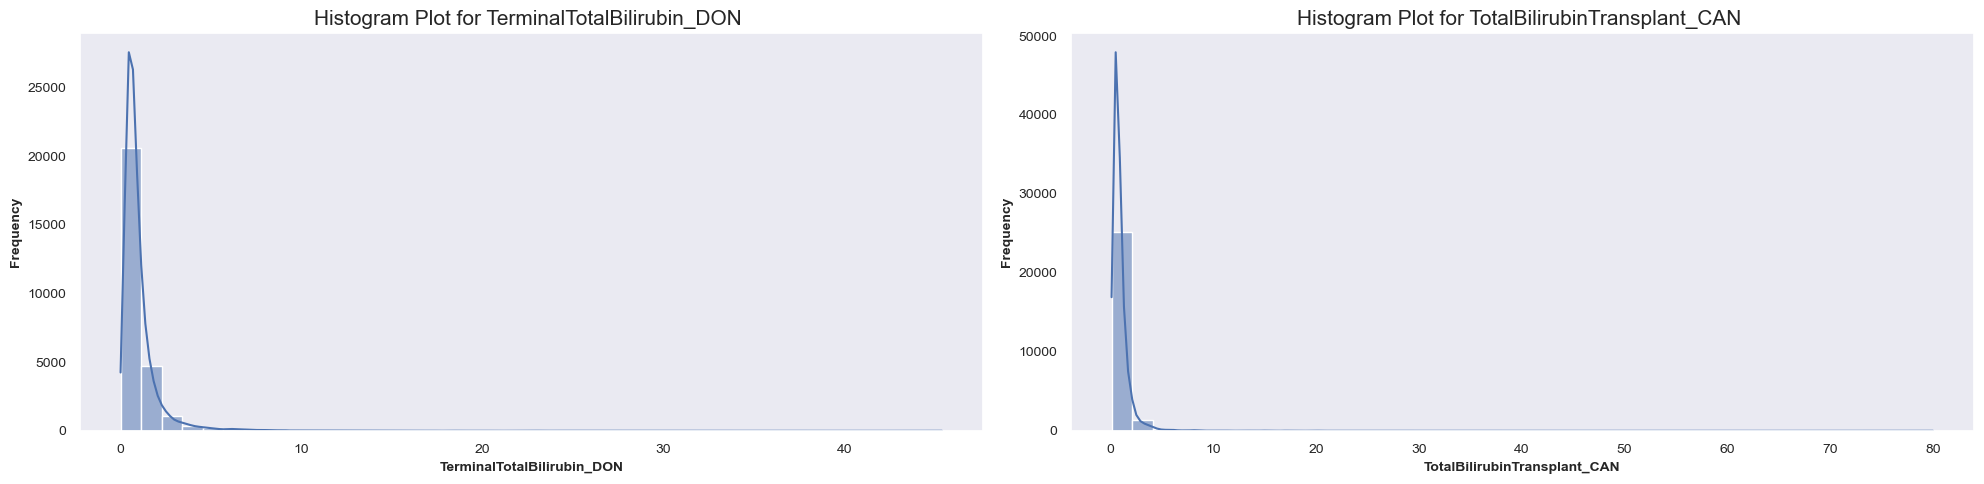

In [29]:
uv.plot_histogram(df_impute, features, bins=40)

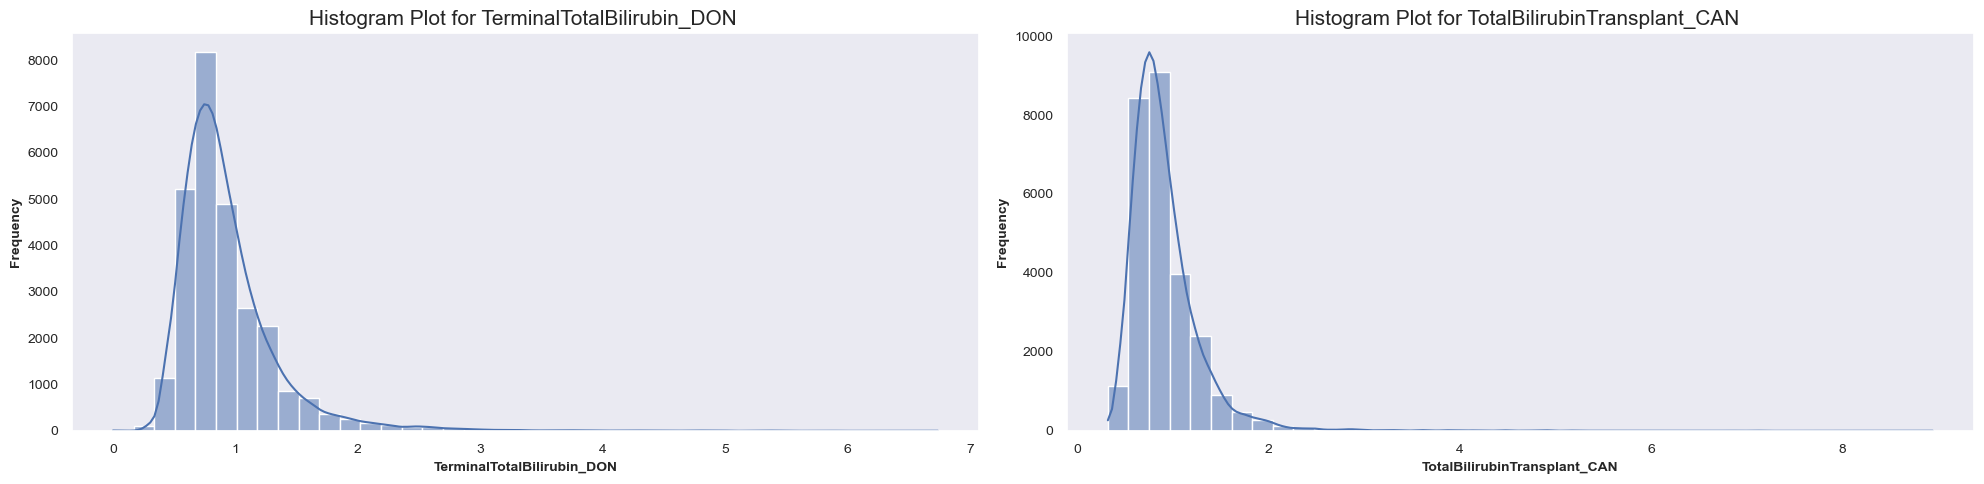

In [30]:
# transform
df_impute[features] = np.sqrt(df_impute[features])
# plot
uv.plot_histogram(df_impute, features, bins=40)

In [31]:
# stats test
usf.test_mcar(pd.DataFrame(df_impute[features]))

Little's MCAR test p-value: 0.5085
✅ Fail to reject null hypothesis: Data may be Missing Completely At Random (MCAR).


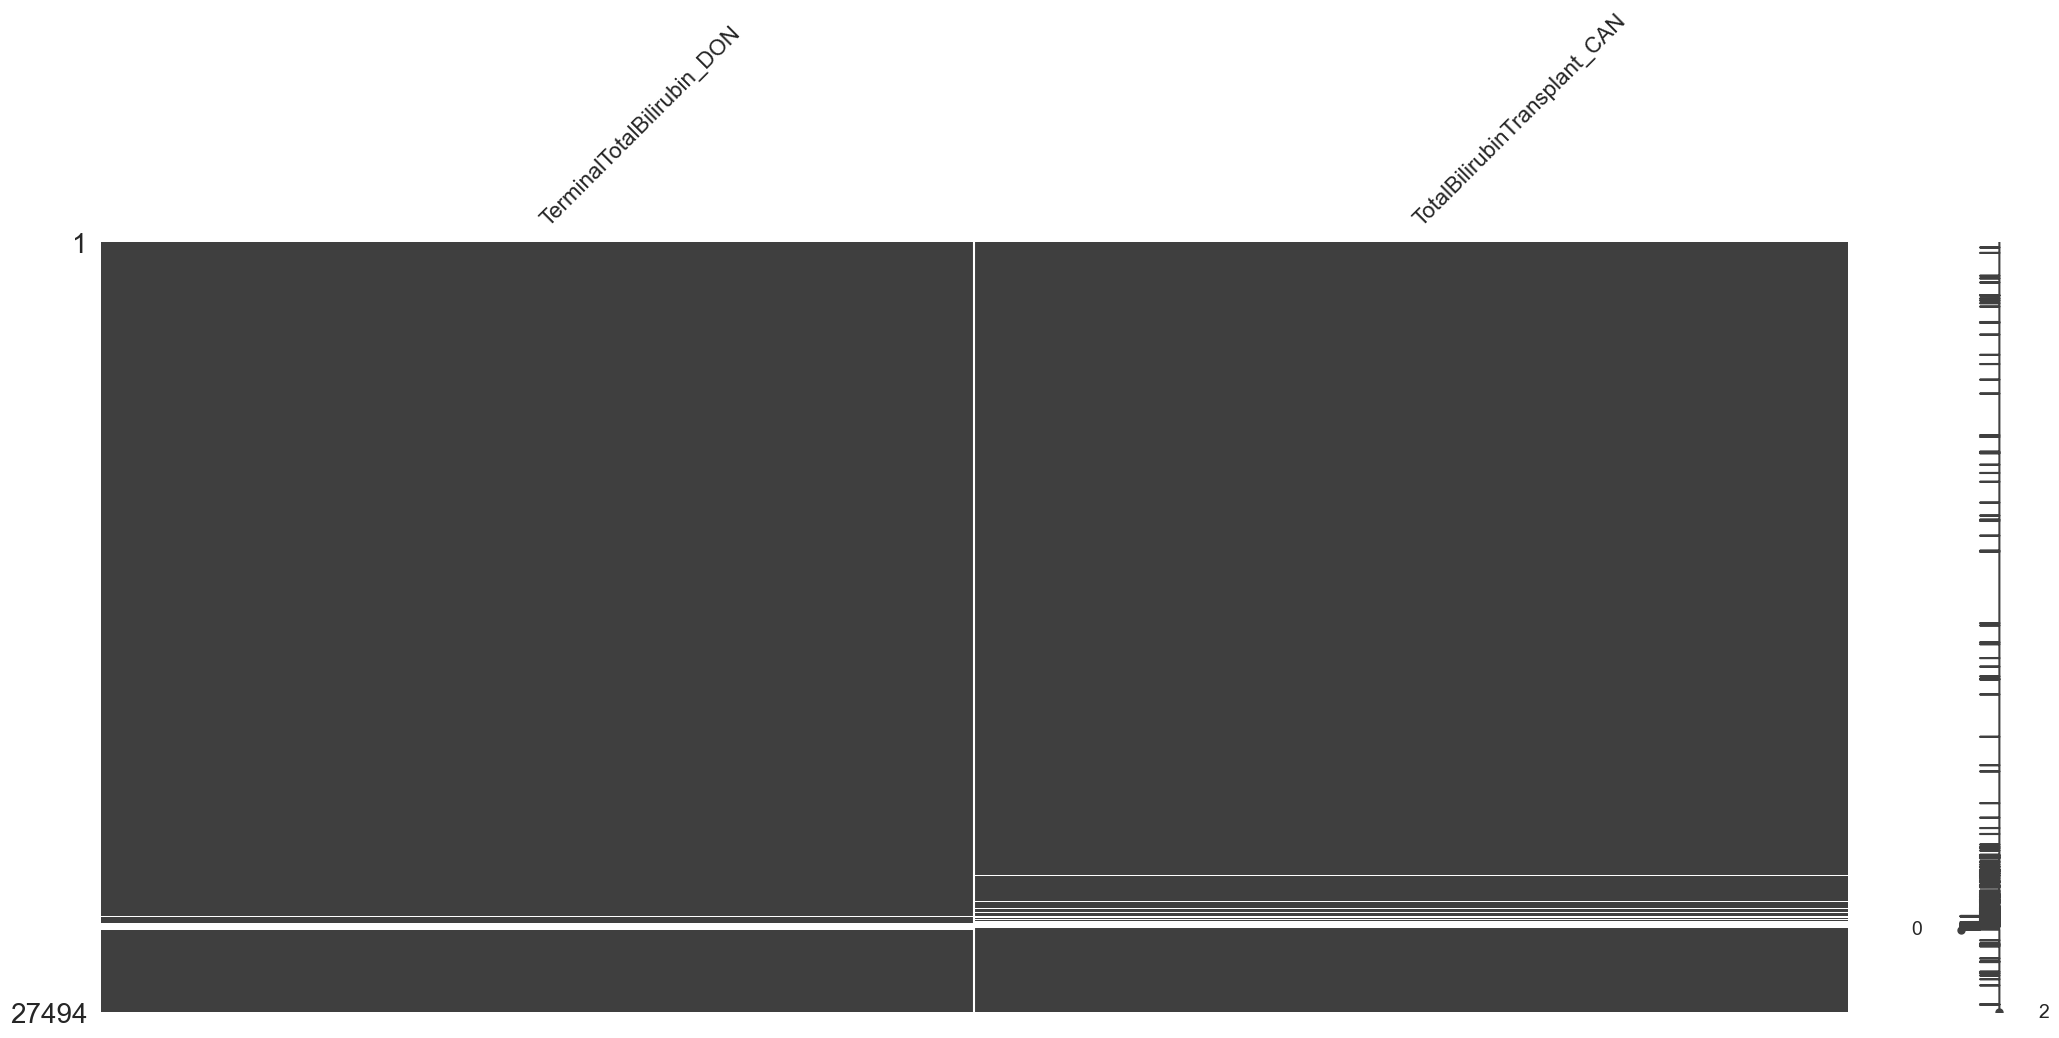

In [32]:
# plot
uv.plot_missingness(df_impute[features])

In [33]:
df_impute[features].corr()

,TerminalTotalBilirubin_DON,TotalBilirubinTransplant_CAN
TerminalTotalBilirubin_DON,1.000000,0.009723
TotalBilirubinTransplant_CAN,0.009723,1.000000


In [34]:
pd.DataFrame(df_impute[features]).describe().T

,count,mean,std,min,25%,50%,75%,max
TerminalTotalBilirubin_DON,27288.0,0.932884,0.417127,0.000000,0.707107,0.83666,1.048809,6.737952
TotalBilirubinTransplant_CAN,27041.0,0.910994,0.406366,0.316228,0.707107,0.83666,1.048809,8.944272


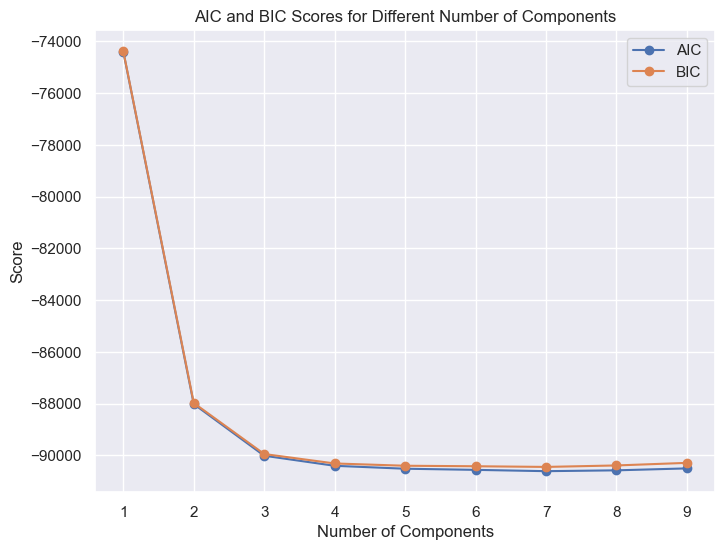

Optimal number of components: 7


In [35]:
# find components
ui.find_gaussian_mixture_components(pd.DataFrame(df_impute['TerminalTotalBilirubin_DON']), component_range=range(1, 10), seed=RANDOM_STATE)

In [36]:
# impute using GMM
imputeGMM = ui.impute_gaussian_mixture(pd.DataFrame(df_impute[features]), RANDOM_STATE, n_components=7)

The best n_neighbors for KNN imputer is: 3
The best weights for KNN imputer is: distance


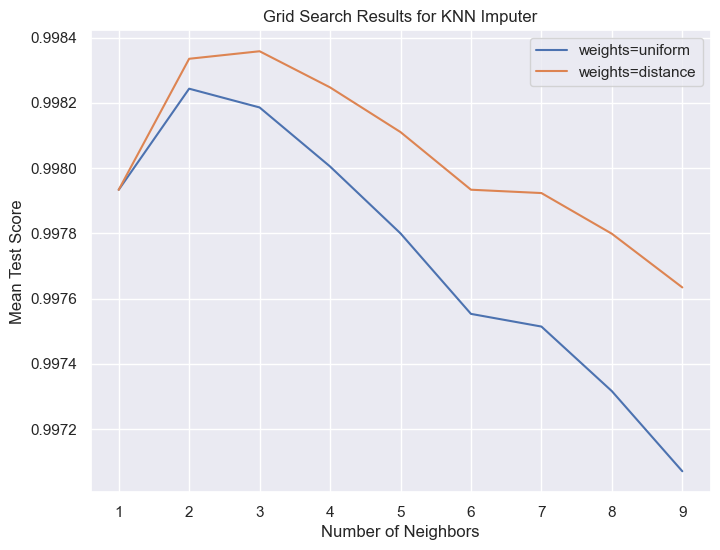

In [37]:
# impute knn
imputeKNN = ui.impute_knn(pd.DataFrame(df_impute[features]))

In [38]:
# calculate the average
imputeAverage = (imputeGMM + imputeKNN) / 2

# update imputed features
df_impute[features] = imputeAverage
# display
pd.DataFrame(df_impute[features]).describe().T

,count,mean,std,min,25%,50%,75%,max
TerminalTotalBilirubin_DON,27494.0,0.931627,0.416155,0.000000,0.707107,0.83666,1.048809,6.737952
TotalBilirubinTransplant_CAN,27494.0,0.914188,0.405704,0.316228,0.707107,0.83666,1.048809,8.944272


In [39]:
# new feature
df_impute['TotalBilirubin_Addition'] = df[features].sum(axis=1)
# display
features = uf.get_feature_list(df_impute, 'Bilirubin')

                                count      mean       std       min       25%      50%       75%        max
TerminalTotalBilirubin_DON    27494.0  0.931627  0.416155  0.000000  0.707107  0.83666  1.048809   6.737952
TotalBilirubinTransplant_CAN  27494.0  0.914188  0.405704  0.316228  0.707107  0.83666  1.048809   8.944272
TotalBilirubin_Addition       27494.0  2.015079  2.242754  0.000000  1.100000  1.50000  2.200000  80.300000

:::: NaN Count:
TerminalTotalBilirubin_DON      0
TotalBilirubinTransplant_CAN    0
TotalBilirubin_Addition         0


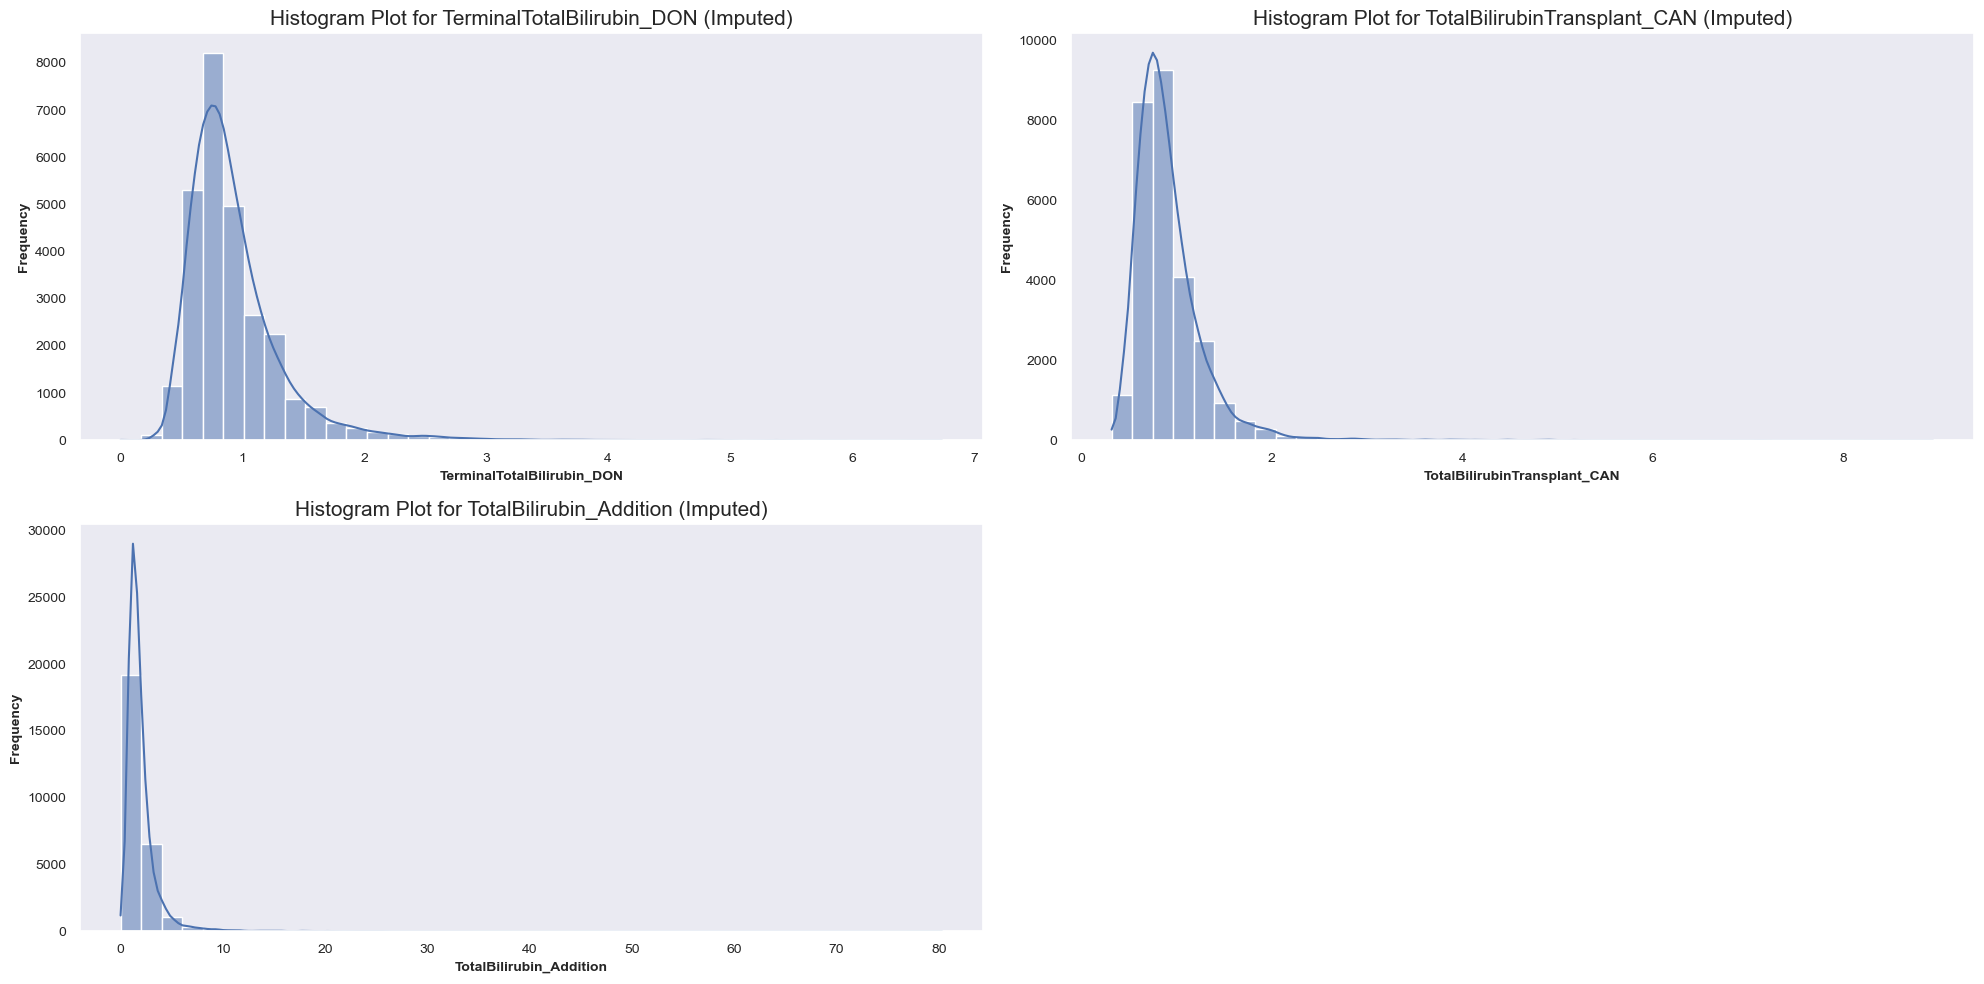

In [40]:
uv.plot_histogram(df_impute, features, txt='(Imputed)', bins=40)

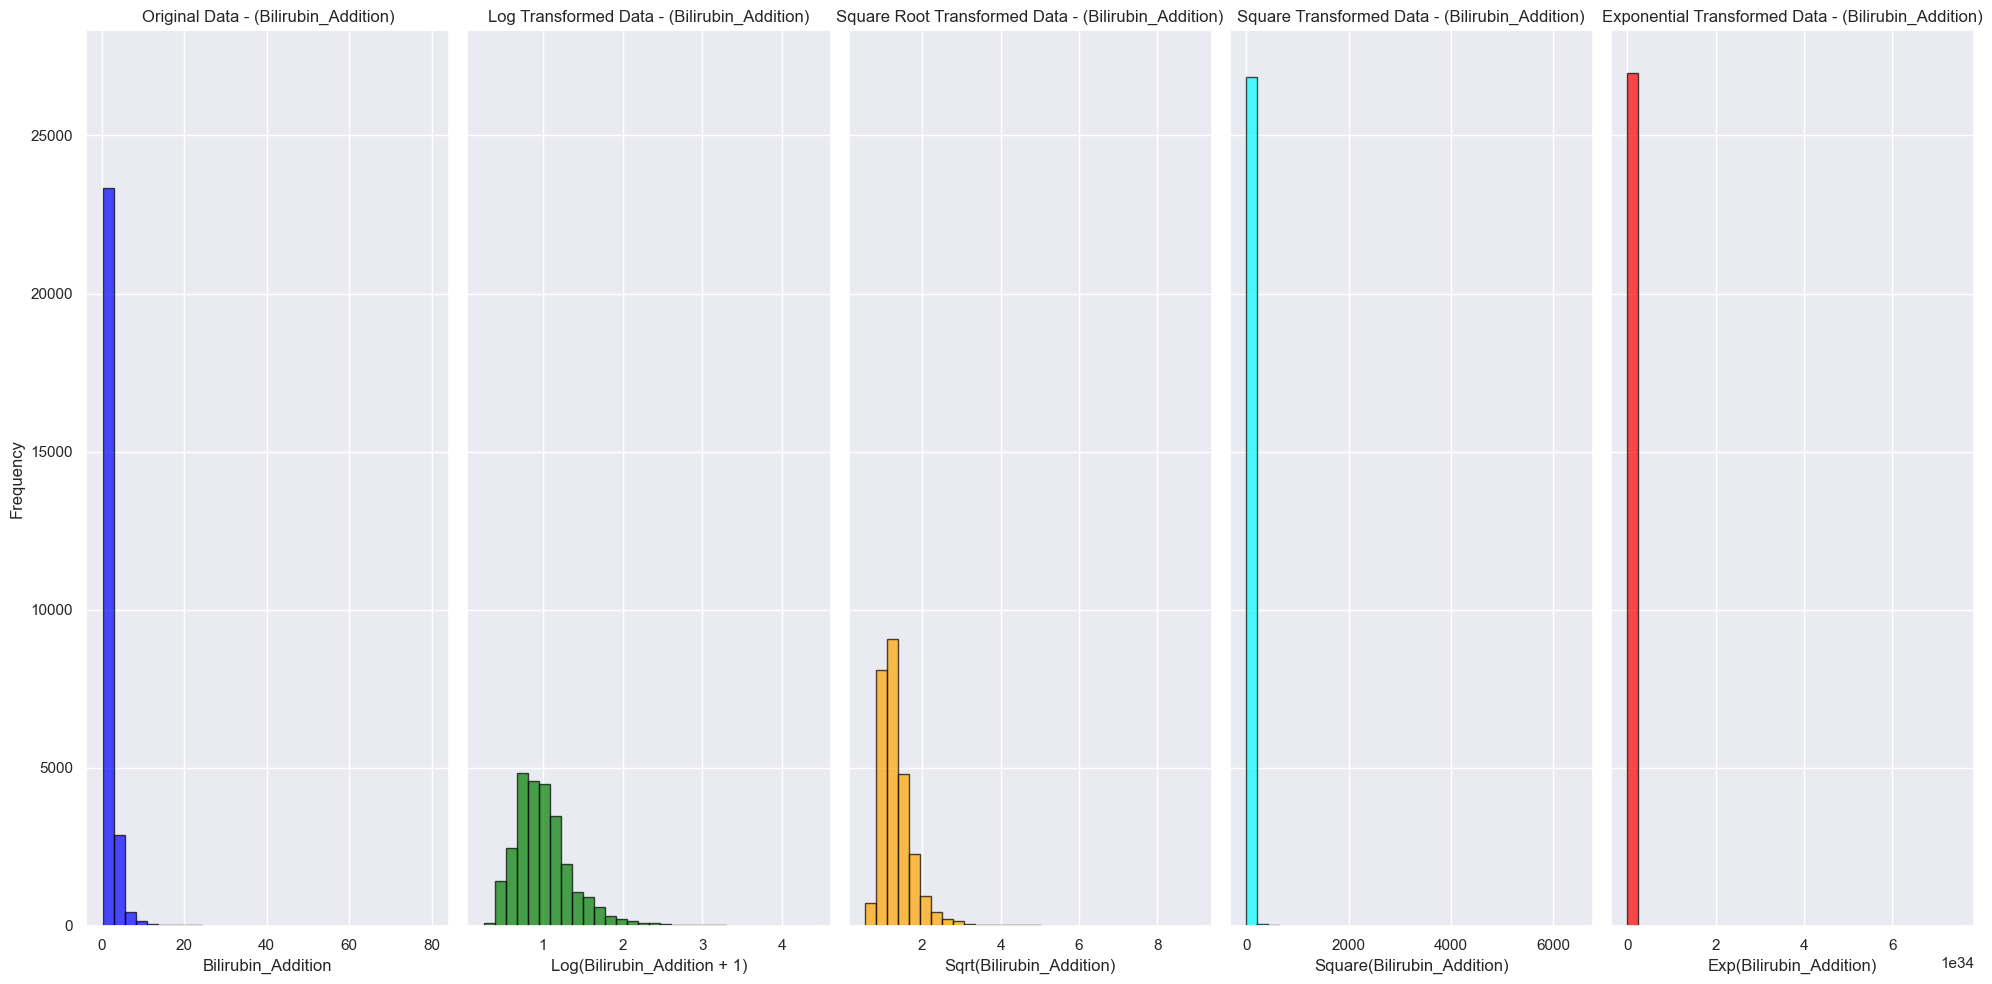

In [41]:
# plot
uv.plot_transform_distribution(df.TotalBilirubin_Addition, txt='Bilirubin_Addition')

In [42]:
# transform TotalBilirubin_Addition
df_impute['TotalBilirubin_Addition'] = np.sqrt(df_impute['TotalBilirubin_Addition'])

#### [OrganRecovery_PCO2_DON](https://www.ncbi.nlm.nih.gov/books/NBK551648/)
- A blood gas test is performed to measure the amount of C02 in the blood. When the lung’s ability to exchange oxygen and C02 becomes impaired, the PC02 level may become increased. The candidate’s current PC02 and change in PC02 are both considered in the lung allocation score calculation to reflect worsening PC02 values. PCO2 is used in the Lung Allocation Score.
- The normal range for the partial pressure of carbon dioxide (pCO2) in arterial blood is typically between 35 to 45 mmHg

In [43]:
features = uf.get_feature_list(df_impute, 'OrganRecovery')

                          count      mean       std   min   25%   50%   75%    max
OrganRecovery_PCO2_DON  27261.0  38.66196  7.050992  10.1  34.0  38.0  42.2  116.3

:::: NaN Count:
OrganRecovery_PCO2_DON    233


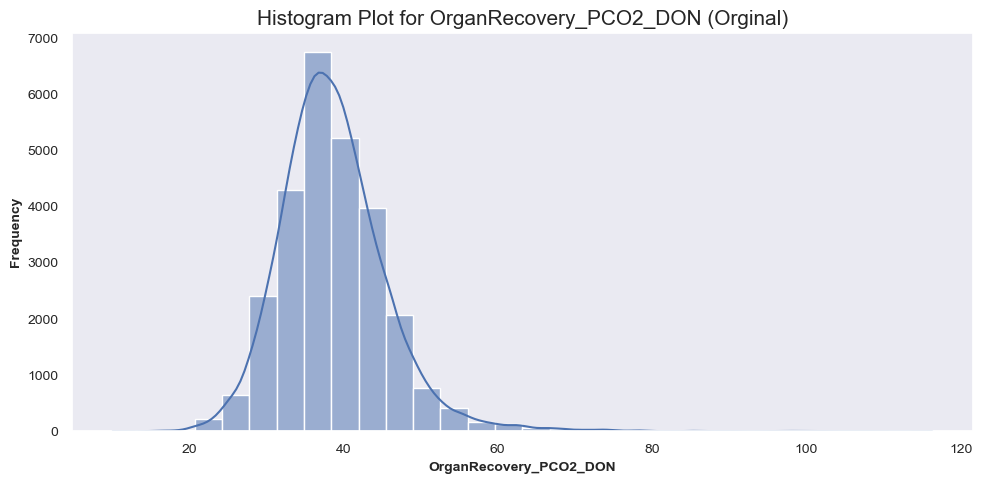

In [44]:
uv.plot_histogram(df_impute, features, txt='(Orginal)', bins=30)

In [45]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: nan
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


In [46]:
# update using mean
df_impute[features] = df_impute[features].fillna(df_impute[features].mean())
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
OrganRecovery_PCO2_DON,27494.0,38.66196,7.02105,10.1,34.0,38.0,42.1,116.3


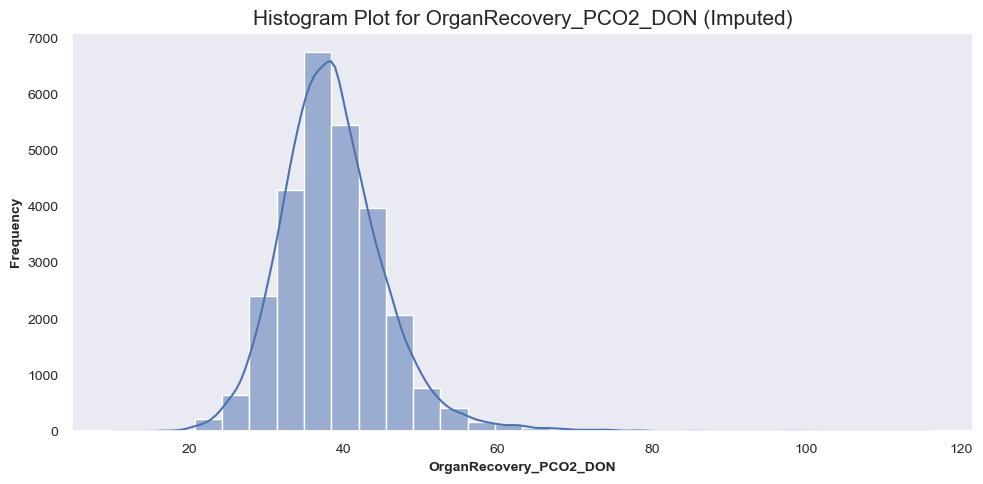

In [47]:
uv.plot_histogram(df_impute, features, txt='(Imputed)', bins=30)

#### BloodPH (Transform)

In [48]:
features = uf.get_feature_list(df_impute, 'BloodPH')

               count      mean    std  min   25%   50%   75%   max
BloodPH_DON  27267.0  7.416161  0.074  5.0  7.38  7.42  7.46  7.93

:::: NaN Count:
BloodPH_DON    227


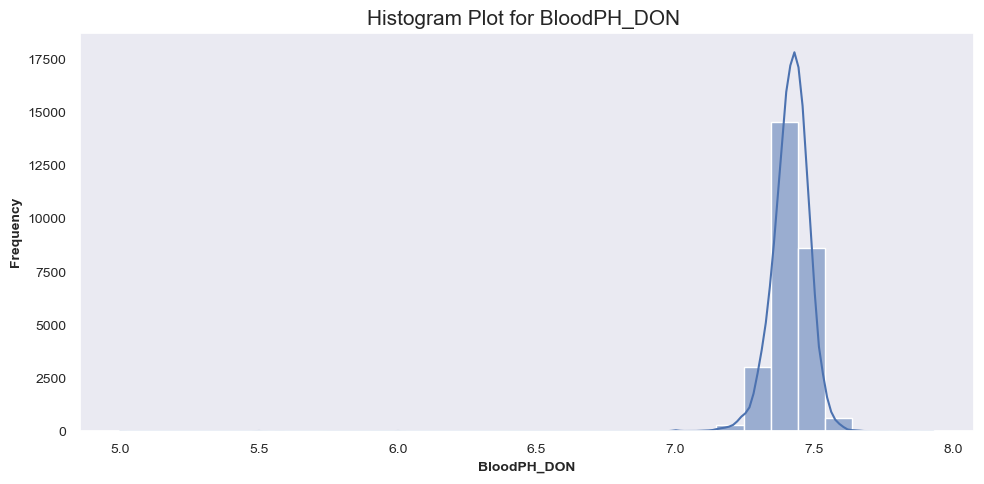

In [49]:
uv.plot_histogram(df_impute, features, bins=30)

In [50]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: nan
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


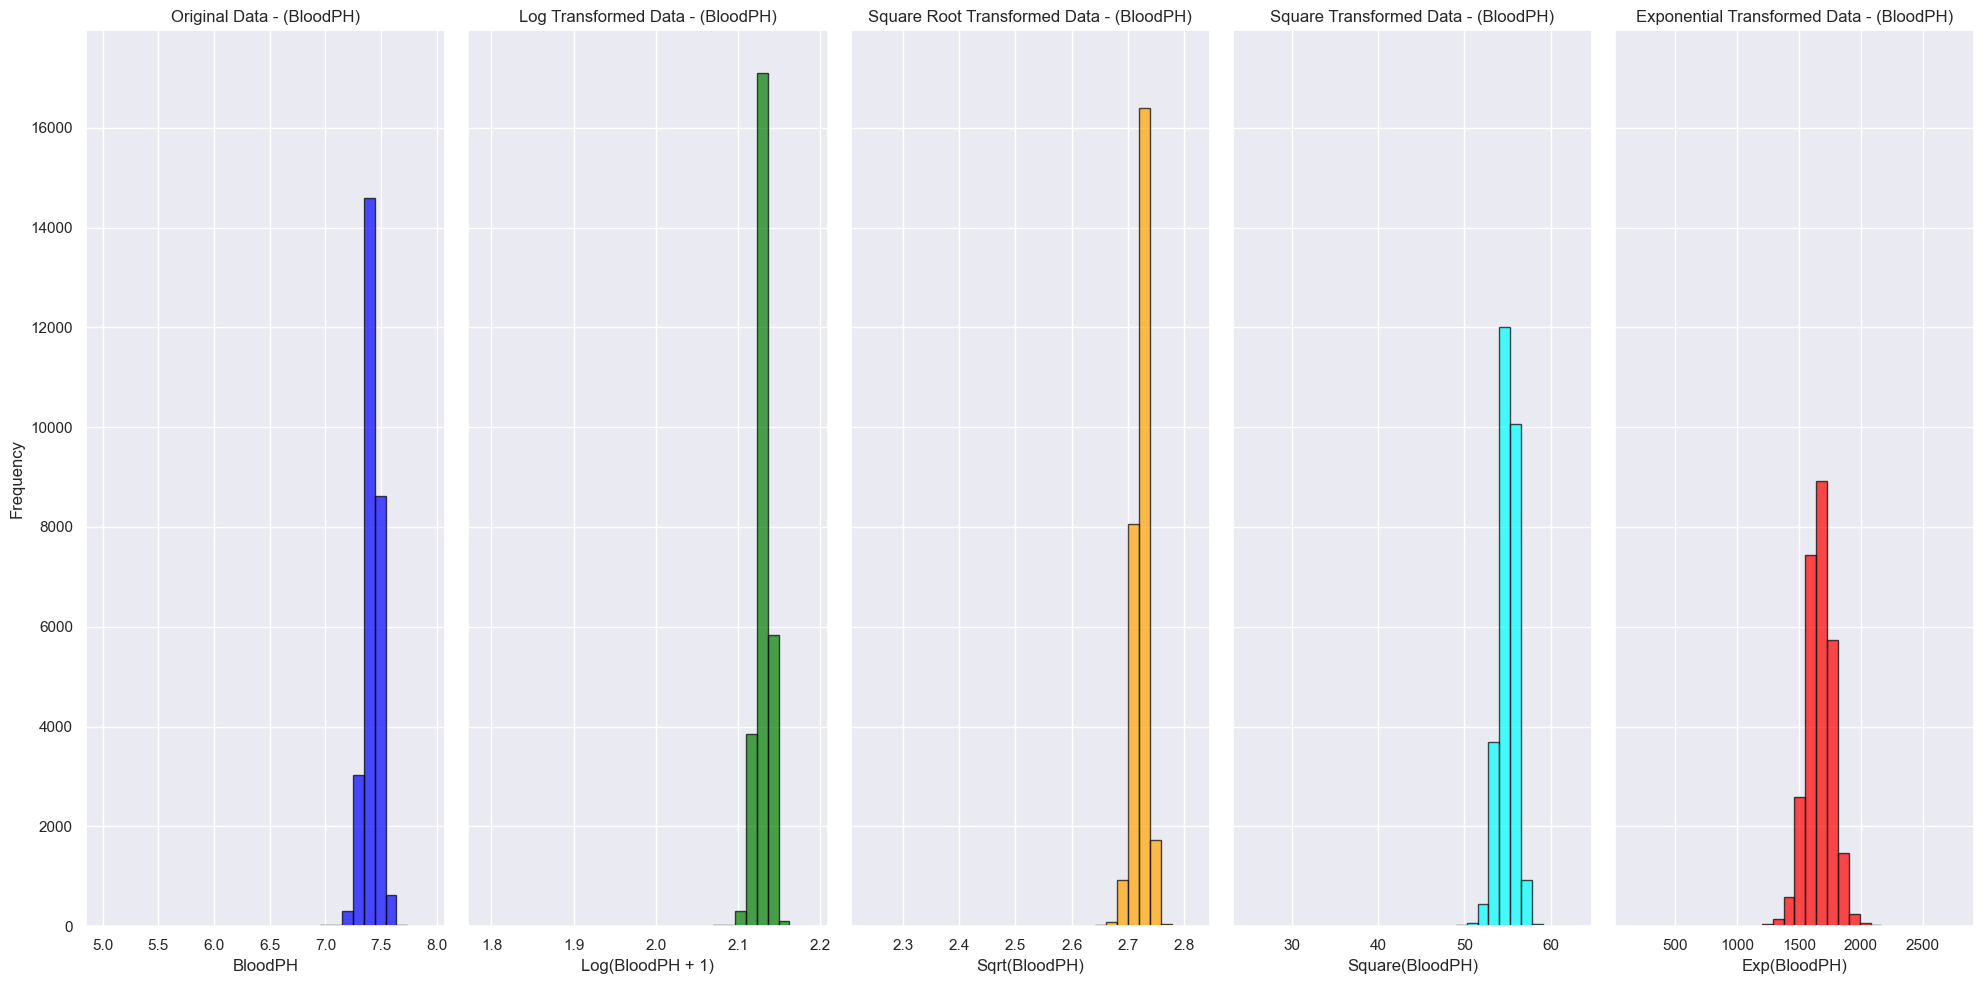

In [51]:
# plot
uv.plot_transform_distribution(df_impute[features], txt='BloodPH', bins=30)

In [52]:
# transform
df_impute[features] =np.exp( df_impute[features])
# update using median
df_impute[features] = df_impute[features].fillna(df_impute[features].median())
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
BloodPH_DON,27494.0,1666.756239,110.229316,148.413159,1603.589768,1669.033508,1737.148057,2779.426805


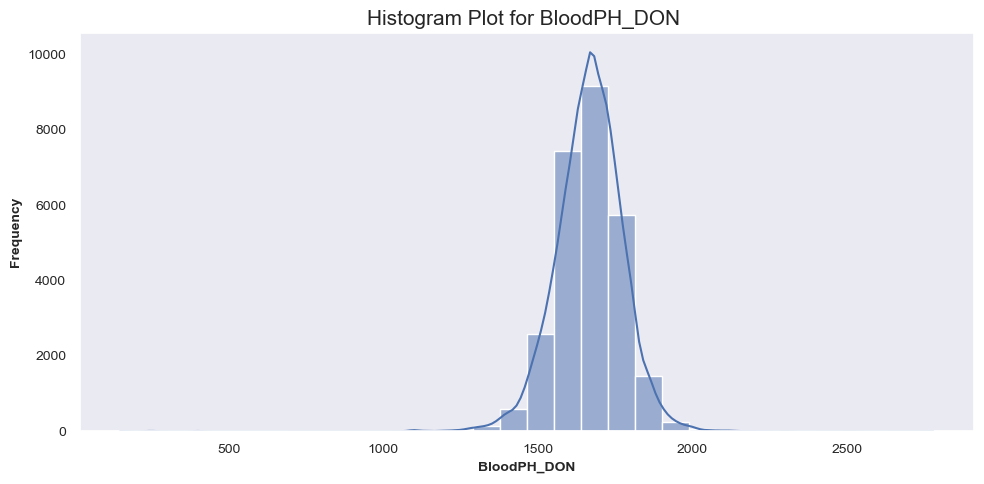

In [53]:
uv.plot_histogram(df_impute, features, bins=30)

#### Level_SGOT (Transform)
- `SGOT`, also known as aspartate aminotransferase `(AST)`, is an enzyme primarily found in the liver, heart, kidneys, and muscles. It plays a crucial role in amino acid metabolism by catalyzing the transfer of an amino group from aspartate to α-ketoglutarate, producing oxaloacetate and glutamate.
    - Conservative normal range of 8 to 45 units/L for healthy individuals. 
- Alanine aminotransferase `(ALT)`, also known as serum glutamic-pyruvic transaminase `(SGPT)`, is an enzyme primarily found in the liver. It plays a crucial role in amino acid metabolism by catalyzing the conversion of alanine and α-ketoglutarate into pyruvate and glutamate. ALT is commonly measured in blood tests to evaluate liver function and detect liver damage.
    - The typical normal range for ALT is approximately 7 to 56 units per liter (U/L) of serum. However, ranges may vary slightly between laboratories. 

In [54]:
features = uf.get_feature_list(df_impute, 'Level_SGOT_ALT|Level_SGOT_AST')

                      count        mean         std  min   25%   50%   75%      max
Level_SGOT_ALT_DON  27287.0  114.875032  408.872451  3.0  23.0  41.0  83.0  44117.0
Level_SGOT_AST_DON  27287.0  102.015934  302.539273  0.3  26.0  44.0  87.0  10254.0

:::: NaN Count:
Level_SGOT_ALT_DON    207
Level_SGOT_AST_DON    207


In [55]:
df_impute[features].corr()

,Level_SGOT_ALT_DON,Level_SGOT_AST_DON
Level_SGOT_ALT_DON,1.000000,0.556127
Level_SGOT_AST_DON,0.556127,1.000000


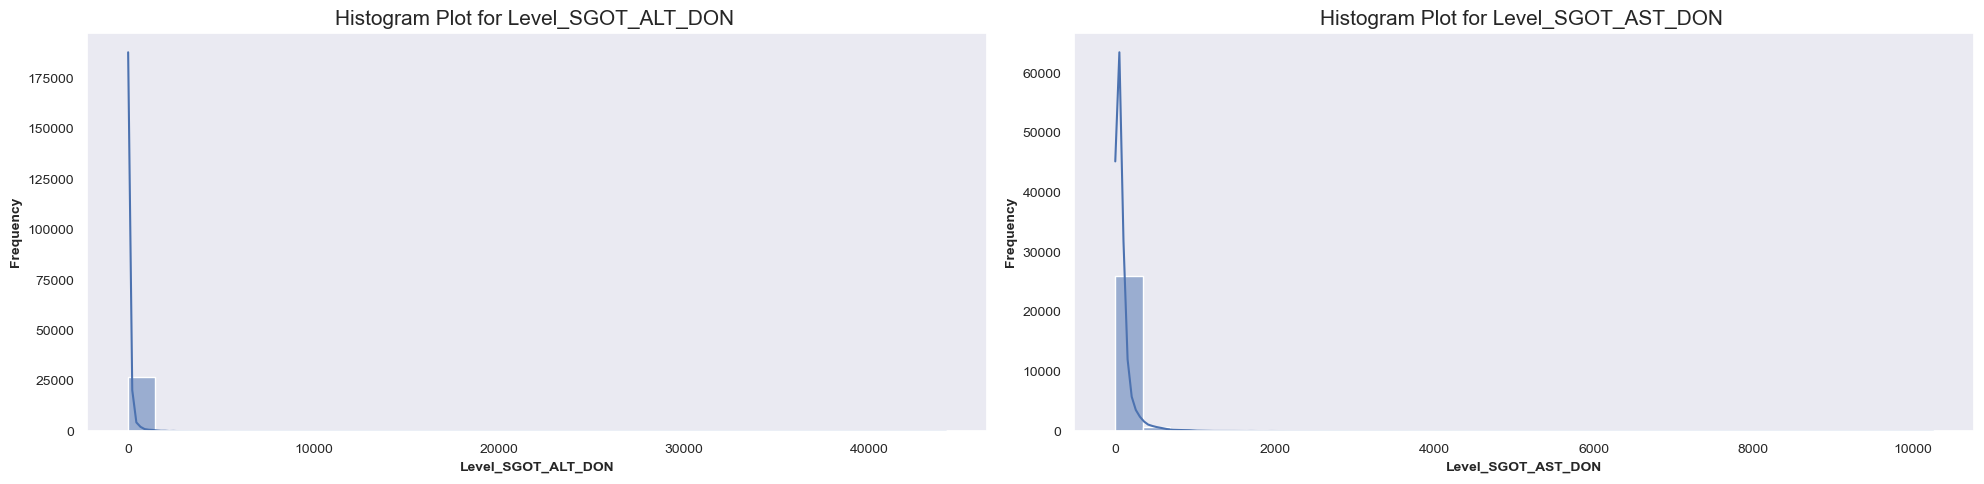

In [56]:
uv.plot_histogram(df_impute, features, bins=30)

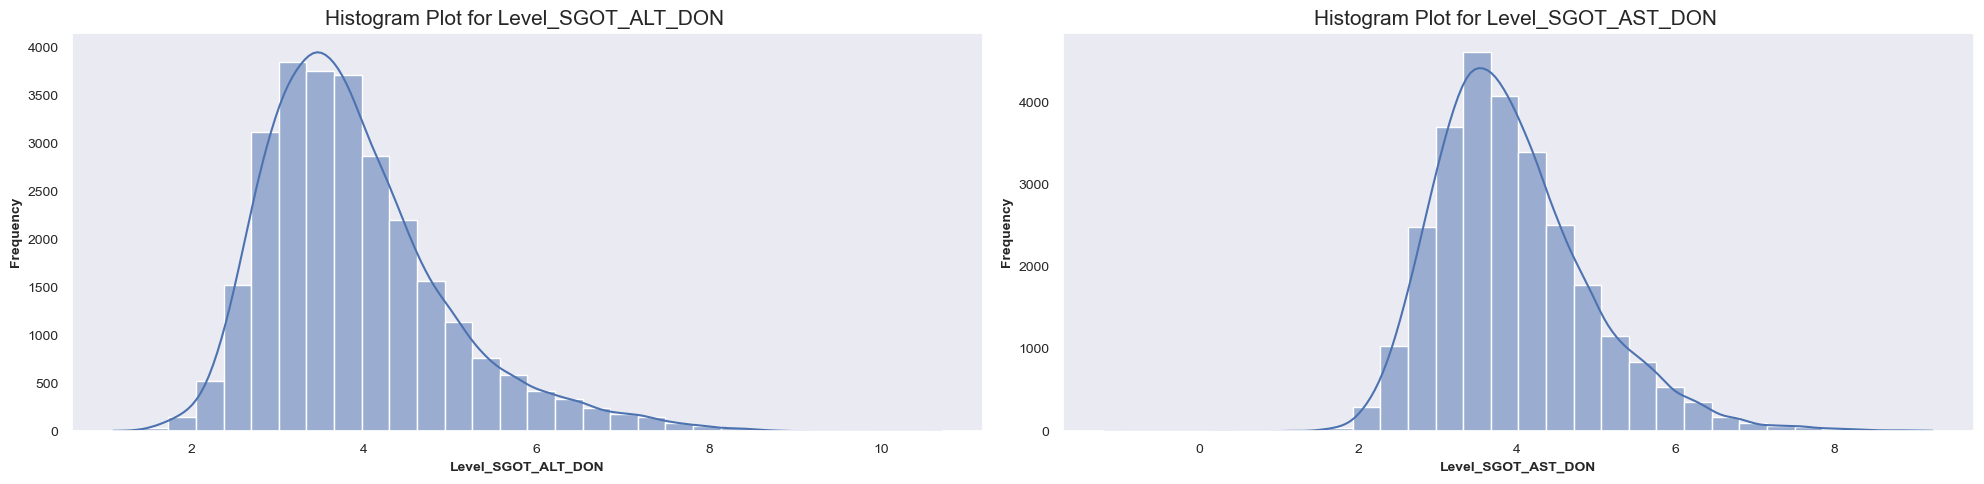

In [57]:
# transform
df_impute[features] = np.log(df_impute[features])
# plot
uv.plot_histogram(df_impute, features, bins=30)

In [58]:
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
Level_SGOT_ALT_DON,27287.0,3.893565,1.066235,1.098612,3.135494,3.713572,4.418841,10.694600
Level_SGOT_AST_DON,27287.0,3.934892,0.979978,-1.203973,3.258097,3.784190,4.465908,9.235423


In [59]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: nan
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


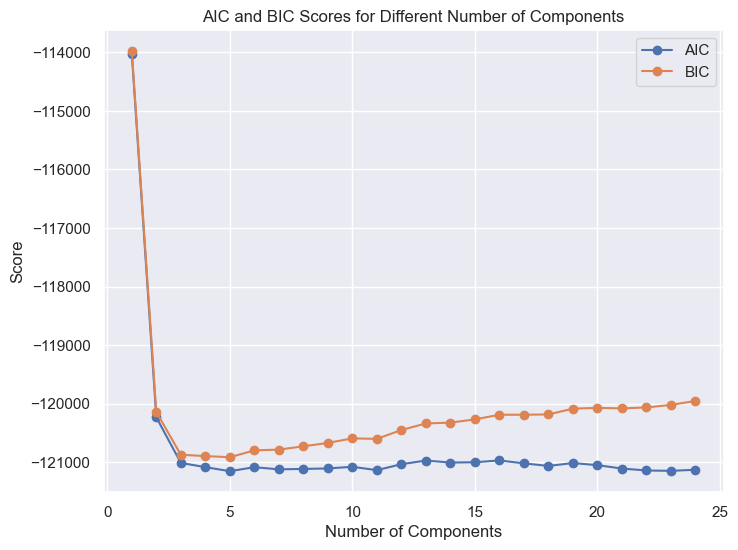

Optimal number of components: 5


In [60]:
# find components
ui.find_gaussian_mixture_components(df_impute[features], component_range=range(1, 25), seed=RANDOM_STATE)

In [61]:
# impute using GMM
imputeGMM = ui.impute_gaussian_mixture(df_impute[features], RANDOM_STATE, n_components=5)

The best n_neighbors for KNN imputer is: 3
The best weights for KNN imputer is: distance


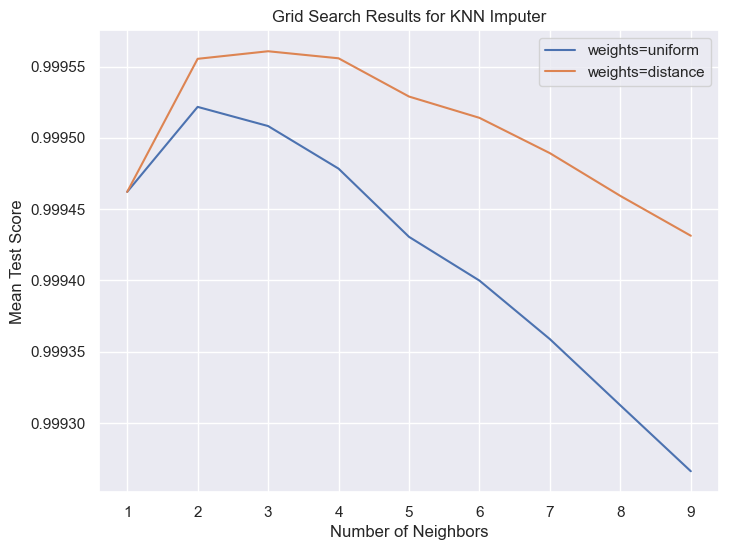

In [62]:
# impute knn
imputeKNN = ui.impute_knn(df_impute[features])

In [63]:
# calculate the average
imputeAverage = (imputeGMM + imputeKNN) / 2

# update imputed features
df_impute[features] = imputeAverage
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
Level_SGOT_ALT_DON,27494.0,3.897014,1.064532,1.098612,3.135494,3.713572,4.430817,10.694600
Level_SGOT_AST_DON,27494.0,3.930762,0.979586,-1.203973,3.258097,3.784190,4.465908,9.235423


In [64]:
# re-calc feature
df_impute['Level_SGOT_Addition_DON'] = df_impute.Level_SGOT_ALT_DON + df_impute.Level_SGOT_AST_DON
# display
features = uf.get_feature_list(df_impute, 'Level_SGOT')

                           count      mean       std       min       25%       50%       75%        max
Level_SGOT_ALT_DON       27494.0  3.897014  1.064532  1.098612  3.135494  3.713572  4.430817  10.694600
Level_SGOT_AST_DON       27494.0  3.930762  0.979586 -1.203973  3.258097  3.784190  4.465908   9.235423
Level_SGOT_Addition_DON  27494.0  7.827776  1.894103  1.648659  6.525030  7.529406  8.791106  18.308192

:::: NaN Count:
Level_SGOT_ALT_DON         0
Level_SGOT_AST_DON         0
Level_SGOT_Addition_DON    0


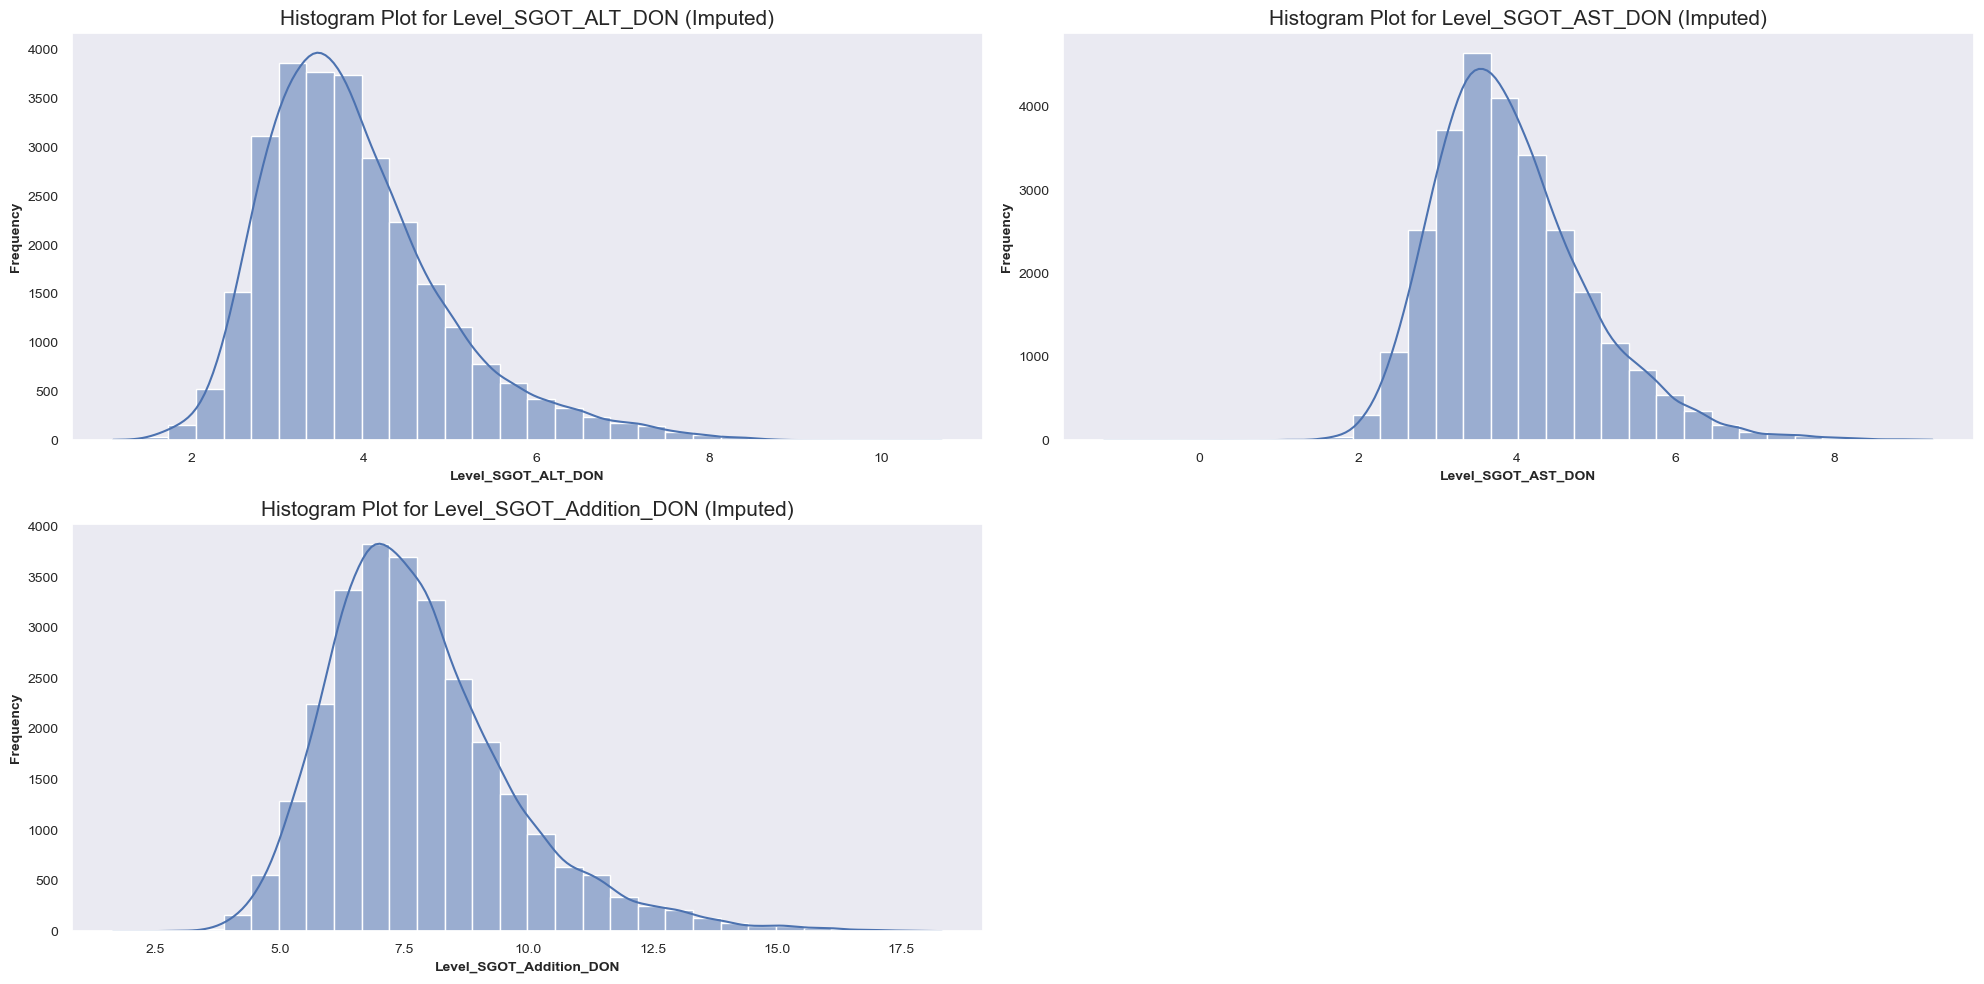

In [65]:
# plot
uv.plot_histogram(df_impute, features, txt='(Imputed)', bins=30)

#### [Creatinine](https://johnshopkinshealthcare.staywellsolutionsonline.com/BreatheEasy/167,creatinine_serum) (Transform)
- Creatinine is a waste product that forms when creatine, a substance found in your muscles, breaks down. It's usually filtered out of the blood by the kidneys and excreted in urine. Measuring creatinine levels in the blood can help assess kidney function.
- High creatinine levels can indicate kidney dysfunction, dehydration, or other conditions affecting the kidneys. If you have concerns about your creatinine levels, it's best to consult with a healthcare professional for proper evaluation and guidance.

In [66]:
# feature information
features = uf.get_feature_list(df_impute, 'Creatinine')

                              count      mean       std   min   25%   50%   75%   max
CreatinineRegistration_CAN  27359.0  1.365684  0.962710  0.08  0.94  1.20  1.50  24.0
CreatinineTransplant_CAN    27076.0  1.373118  1.009271  0.06  0.94  1.20  1.50  37.0
Creatinine_Addition         26951.0  4.241332  2.342882  0.91  2.97  3.61  4.63  50.3
Creatinine_DON              27291.0  1.505226  1.557918  0.04  0.76  1.00  1.50  23.0

:::: NaN Count:
CreatinineRegistration_CAN    135
CreatinineTransplant_CAN      418
Creatinine_Addition           543
Creatinine_DON                203


In [67]:
df_impute[features].corr()

,CreatinineRegistration_CAN,CreatinineTransplant_CAN,Creatinine_Addition,Creatinine_DON
CreatinineRegistration_CAN,1.000000,0.676508,0.677276,-0.037203
CreatinineTransplant_CAN,0.676508,1.000000,0.693036,-0.023678
Creatinine_Addition,0.677276,0.693036,1.000000,0.638085
Creatinine_DON,-0.037203,-0.023678,0.638085,1.000000


In [68]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: 0.0000
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


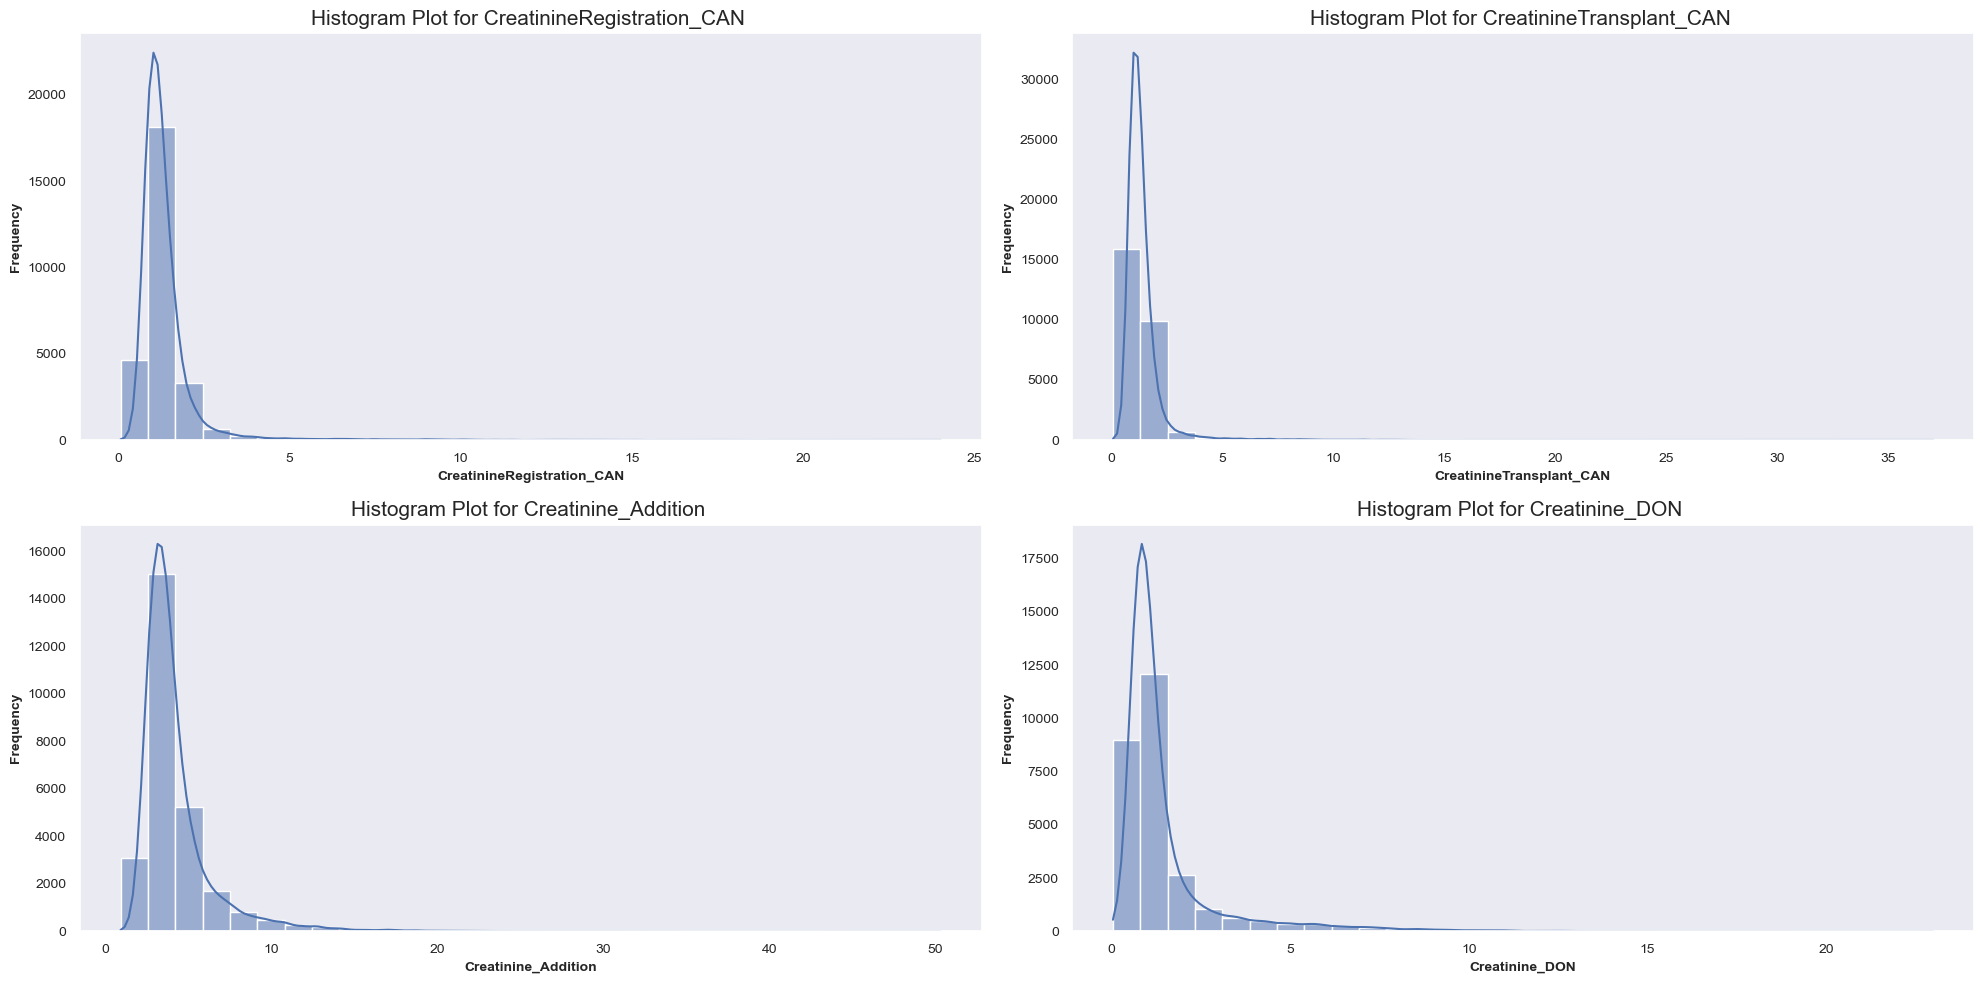

In [69]:
uv.plot_histogram(df_impute, features, bins=30)

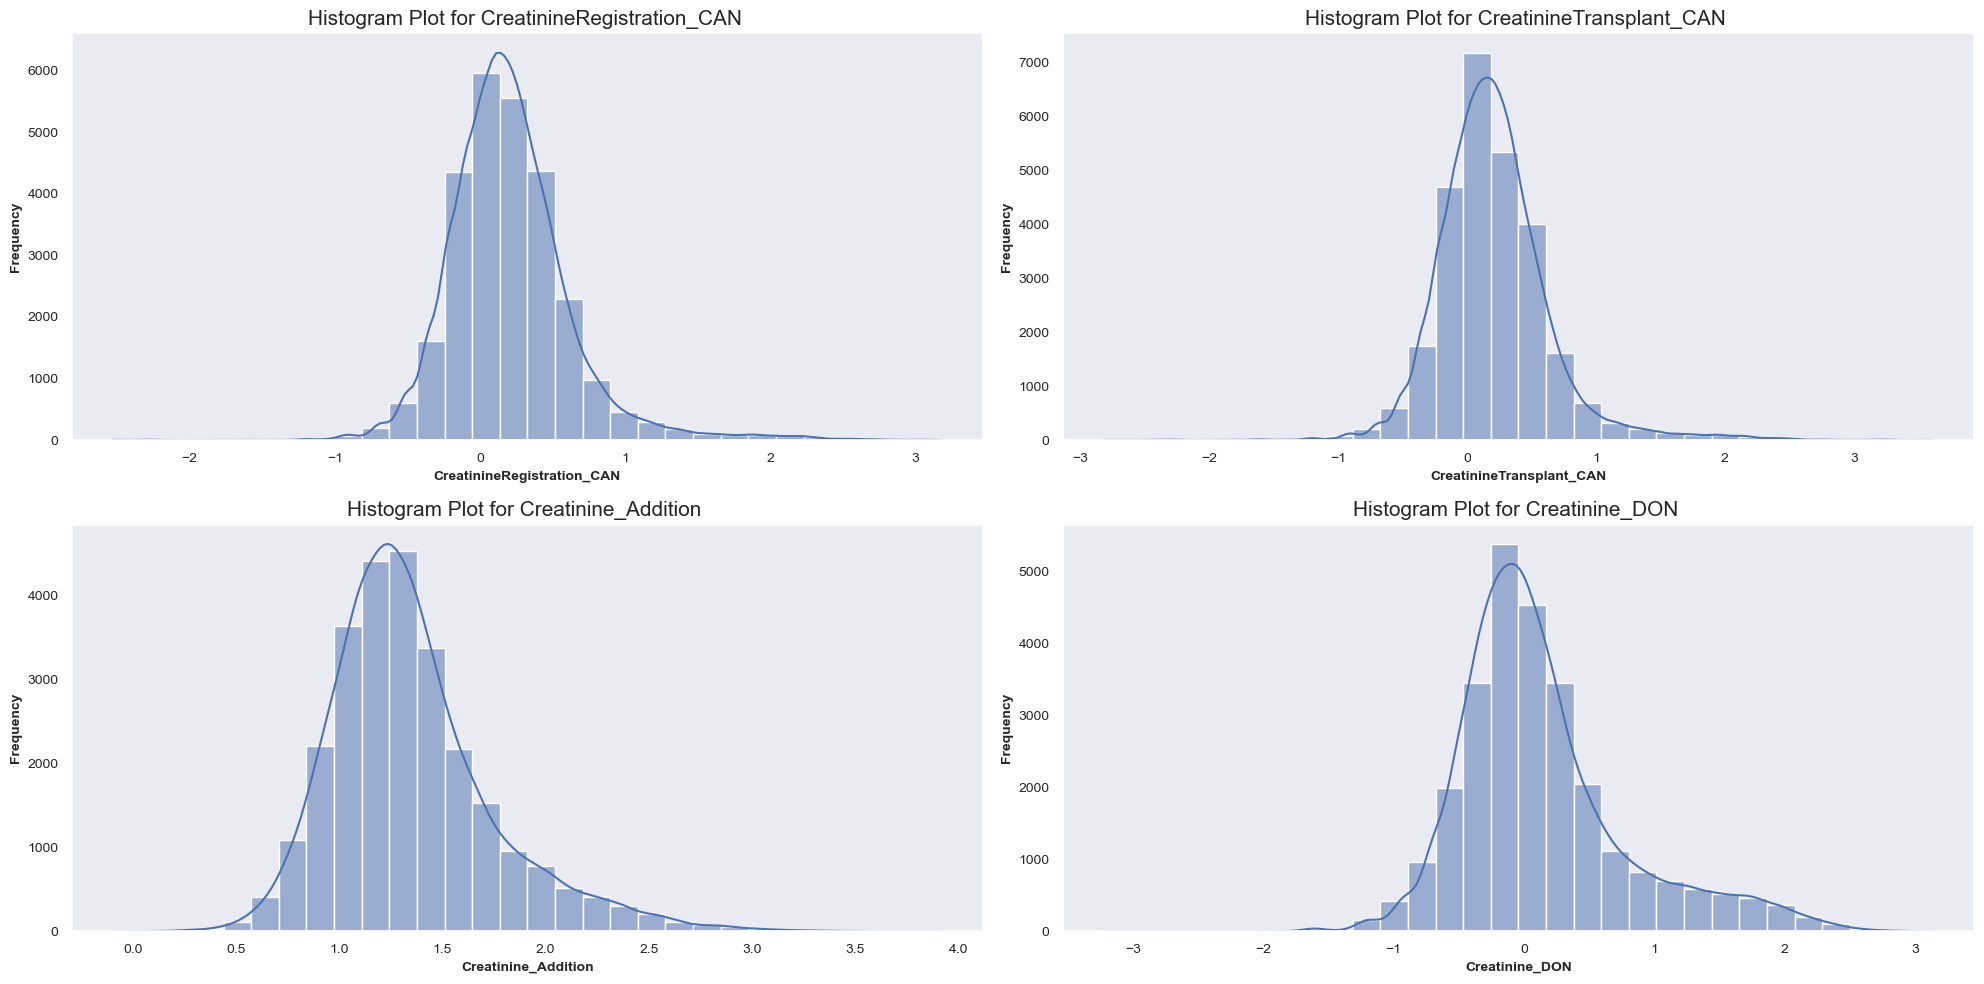

In [70]:
# transform
df_impute[features] = np.log(df_impute[features])
# plot
uv.plot_histogram(df_impute, features, bins=30)

In [71]:
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
CreatinineRegistration_CAN,27359.0,0.201314,0.418876,-2.525729,-0.061875,0.182322,0.405465,3.178054
CreatinineTransplant_CAN,27076.0,0.202980,0.427177,-2.813411,-0.061875,0.182322,0.405465,3.610918
Creatinine_Addition,26951.0,1.350267,0.401642,-0.094311,1.088562,1.283708,1.532557,3.918005
Creatinine_DON,27291.0,0.137688,0.652401,-3.218876,-0.274437,0.000000,0.405465,3.135494


In [72]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: 0.0022
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


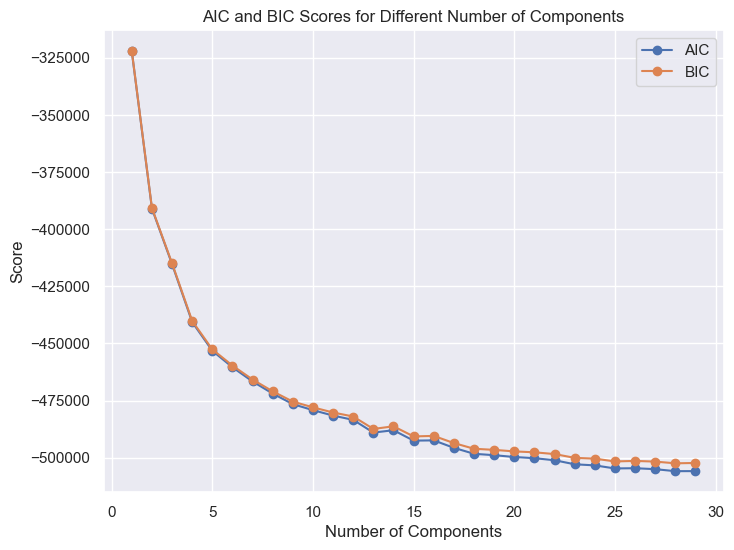

Optimal number of components: 28


In [73]:
# find components
ui.find_gaussian_mixture_components(df_impute[features], component_range=range(1, 30), seed=RANDOM_STATE)

In [74]:
# impute using GMM
imputeGMM = ui.impute_gaussian_mixture(df_impute[features], RANDOM_STATE, n_components=28)

The best n_neighbors for KNN imputer is: 3
The best weights for KNN imputer is: distance


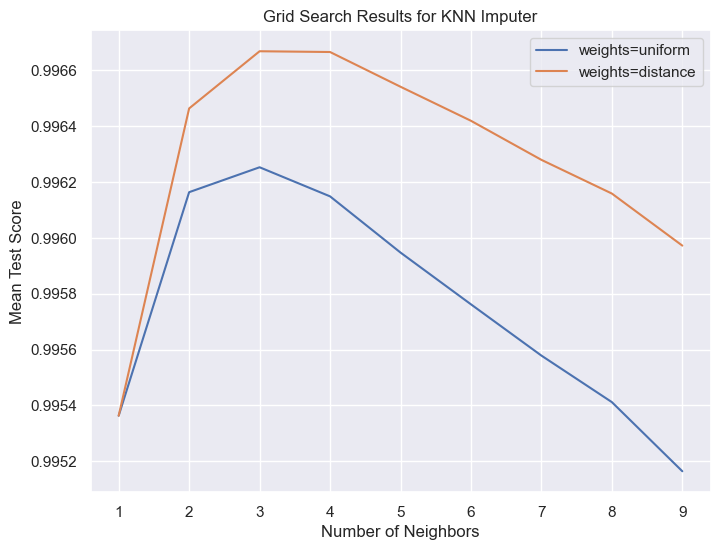

In [75]:
# impute knn
imputeKNN = ui.impute_knn(df_impute[features])

In [76]:
# calculate the average
imputeAverage = (imputeGMM + imputeKNN) / 2

# update imputed features
df_impute[features] = imputeAverage
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
CreatinineRegistration_CAN,27494.0,0.200758,0.418409,-2.525729,-0.061875,0.182322,0.405465,3.178054
CreatinineTransplant_CAN,27494.0,0.203182,0.426605,-2.813411,-0.061875,0.182322,0.405465,3.610918
Creatinine_Addition,27494.0,1.354748,0.401094,-0.094311,1.095273,1.291984,1.542911,3.918005
Creatinine_DON,27494.0,0.135878,0.651161,-3.218876,-0.274437,0.000000,0.398776,3.135494


#### BloodUreaNitrogenLevel (Transform)

In [77]:
features = uf.get_feature_list(df_impute, 'BloodUreaNitrogenLevel')

                              count       mean        std  min   25%   50%   75%    max
BloodUreaNitrogenLevel_DON  27291.0  24.272559  20.110485  0.5  12.0  18.0  29.0  250.0

:::: NaN Count:
BloodUreaNitrogenLevel_DON    203


In [78]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: nan
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


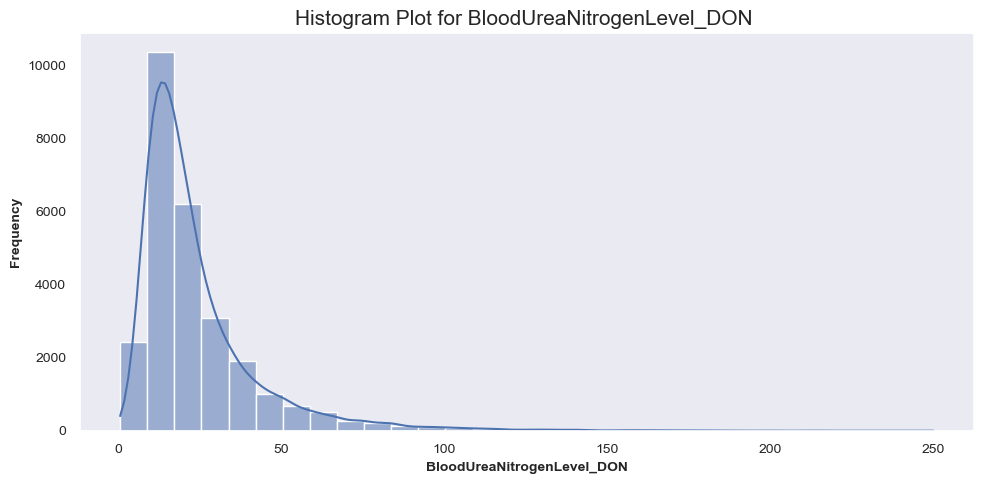

In [79]:
uv.plot_histogram(df_impute, features, bins=30)

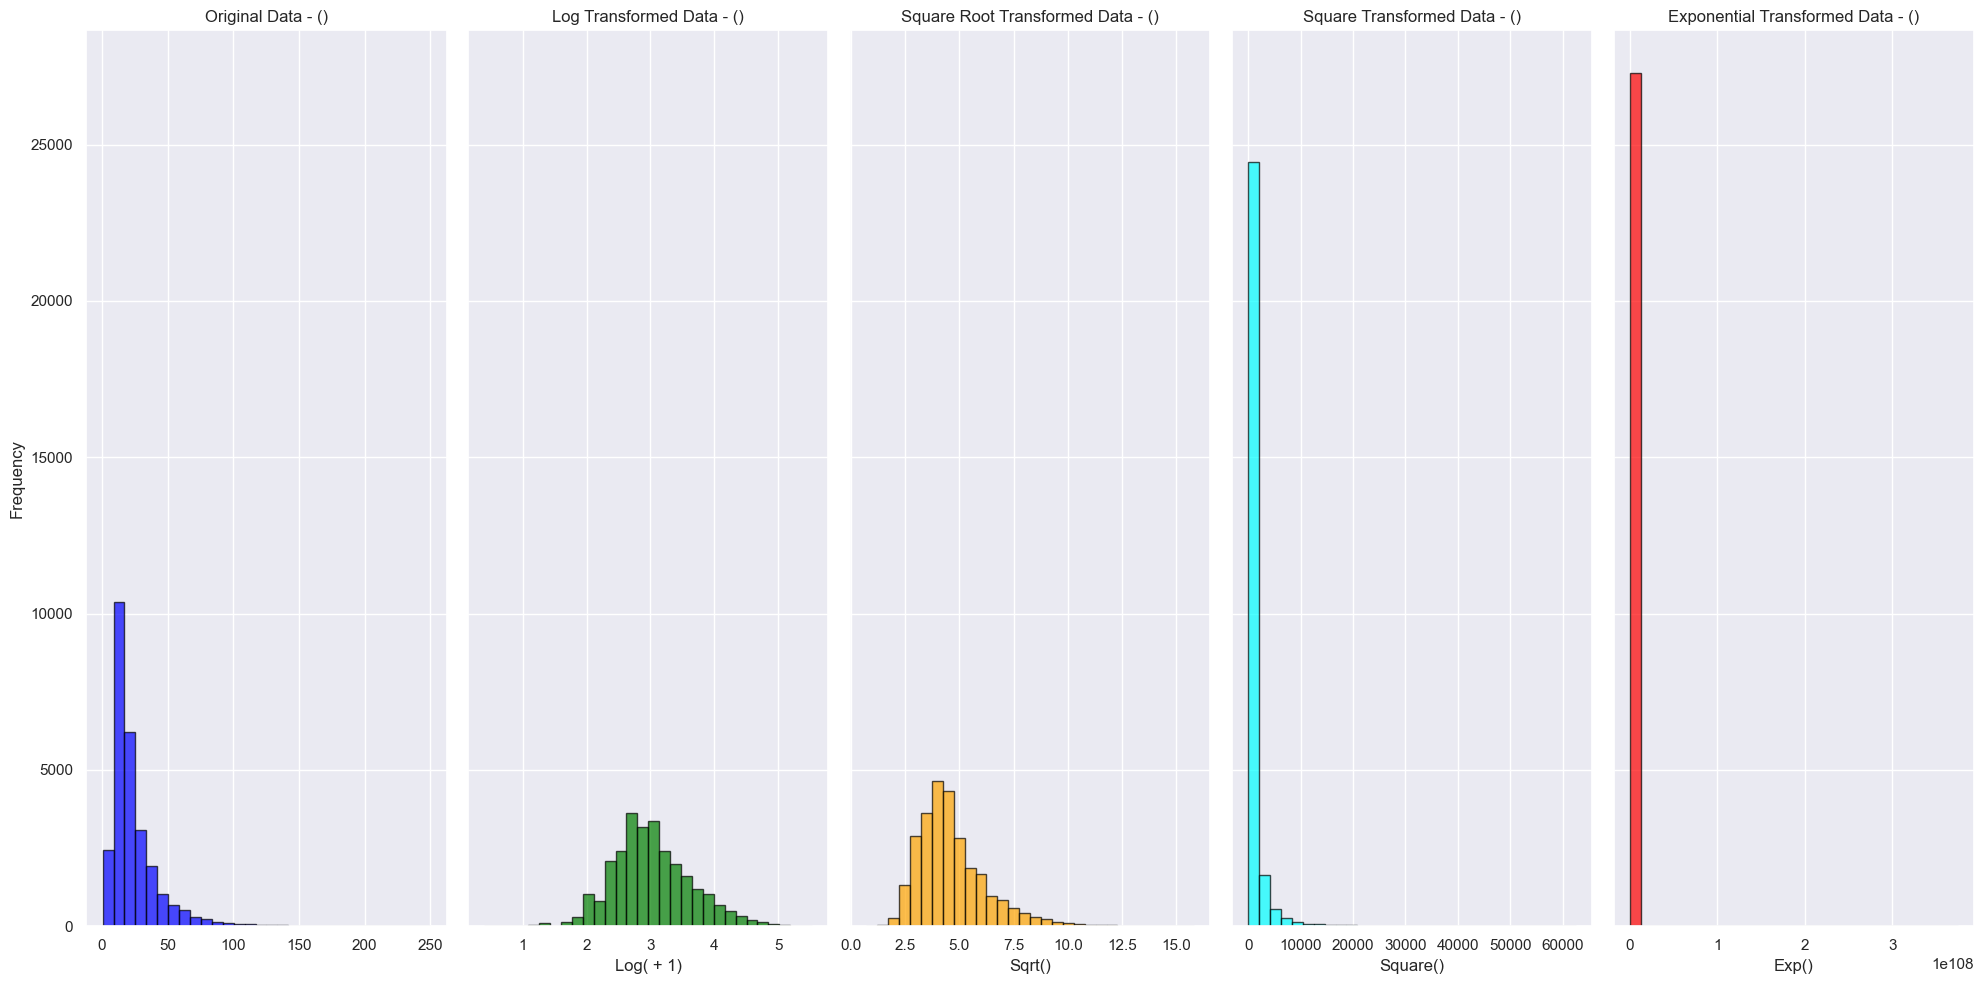

In [80]:
uv.plot_transform_distribution(df_impute[features],bins=30)

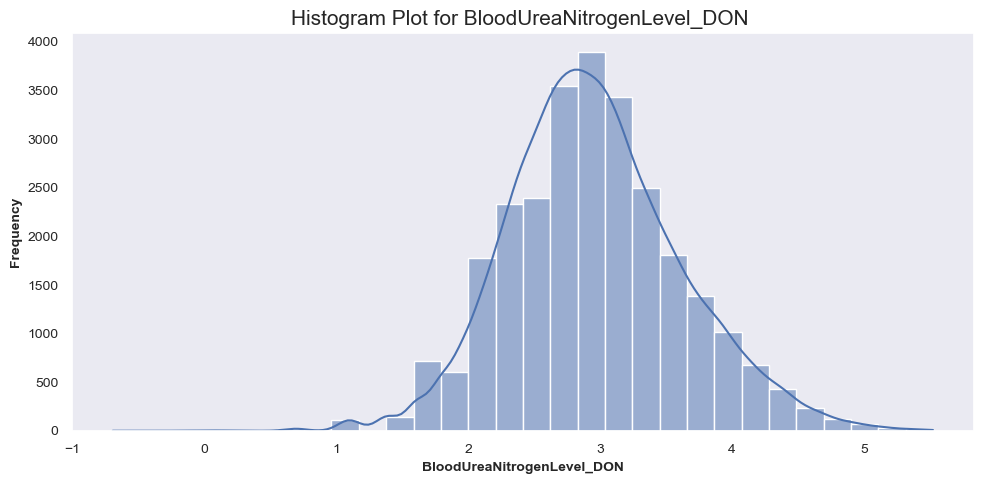

In [81]:
# transform
df_impute[features] = np.log(df_impute[features])
# plot
uv.plot_histogram(df_impute, features, bins=30)

In [82]:
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
BloodUreaNitrogenLevel_DON,27291.0,2.956985,0.659618,-0.693147,2.484907,2.890372,3.367296,5.521461


In [83]:
# update with median
df_impute[features] = df_impute[features].fillna(df_impute[features].median())
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
BloodUreaNitrogenLevel_DON,27494.0,2.956494,0.657203,-0.693147,2.484907,2.890372,3.367296,5.521461


#### [Hematocrit_DON](https://www.mountsinai.org/health-library/tests/hematocrit) (Transform)
- Hematocrit is a blood test that measures how much of a person's blood is made up of red blood cells as opposed to plasma.
    - Normal results vary, but in general they are:
        - Male: 40.7% to 50.3%
        - Female: 36.1% to 44.3% 

In [84]:
features = uf.get_feature_list(df_impute, 'Hematocrit')

                  count       mean     std  min   25%   50%   75%   max
Hematocrit_DON  27291.0  28.397493  5.0099  2.3  25.0  27.9  31.3  75.0

:::: NaN Count:
Hematocrit_DON    203


In [85]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: nan
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


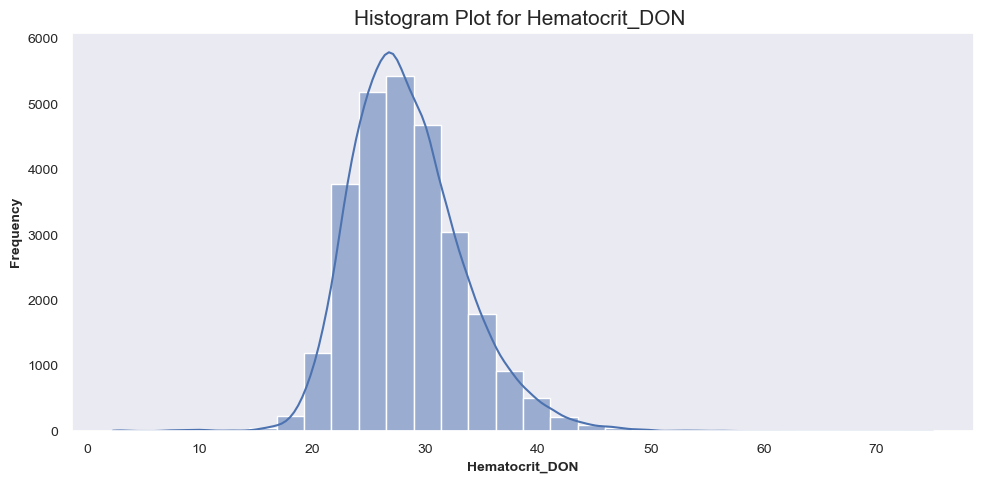

In [86]:
uv.plot_histogram(df_impute, features, bins=30)

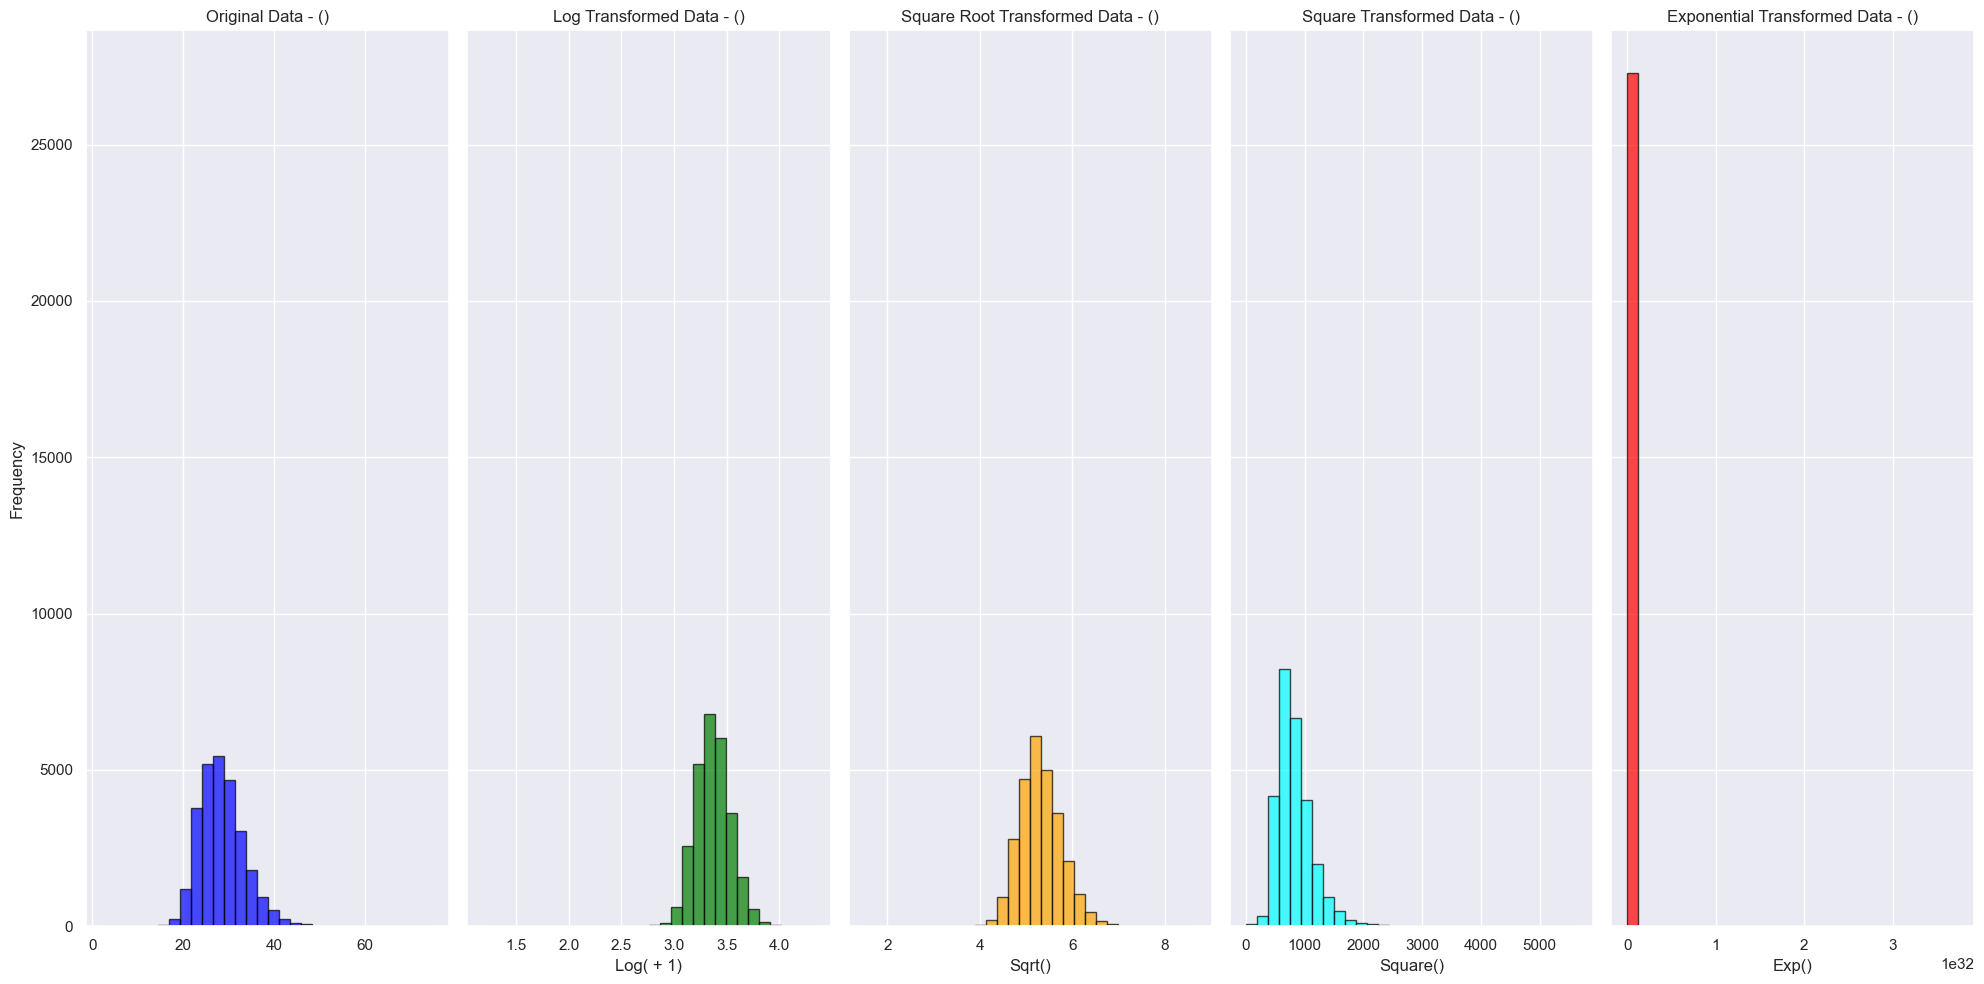

In [87]:
uv.plot_transform_distribution(df_impute[features],bins=30)

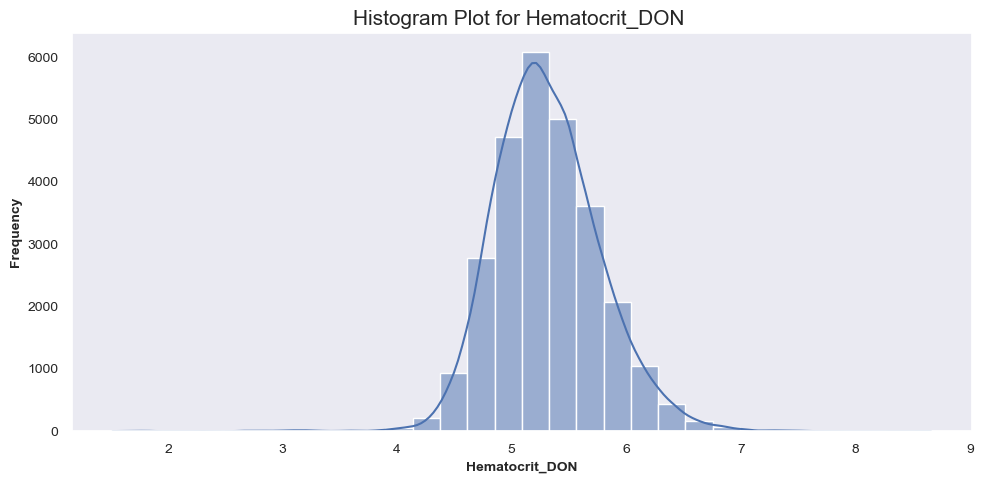

In [88]:
# transform
df_impute[features] = np.sqrt(df_impute[features])
# plot
uv.plot_histogram(df_impute, features, bins=30)

In [89]:
# update with median
df_impute[features] = df_impute[features].fillna(df_impute[features].median())
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
Hematocrit_DON,27494.0,5.308164,0.466076,1.516575,5.0,5.282045,5.585696,8.660254


#### [LV_EjectionFractionPercent](https://my.clevelandclinic.org/health/articles/16950-ejection-fraction)
- Ejection fraction measures your heart’s ability to pump oxygen-rich blood out to your body. In a healthy heart, the fraction is a higher number. A low number means that your heart has difficulty keeping up with your body’s needs.

In [90]:
features = uf.get_feature_list(df_impute, 'LV_EjectionFractionPercent')

                                  count       mean       std   min   25%   50%   75%   max
LV_EjectionFractionPercent_DON  27463.0  61.619236  6.645749  10.0  56.0  60.0  65.0  99.0

:::: NaN Count:
LV_EjectionFractionPercent_DON    31


In [91]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: nan
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


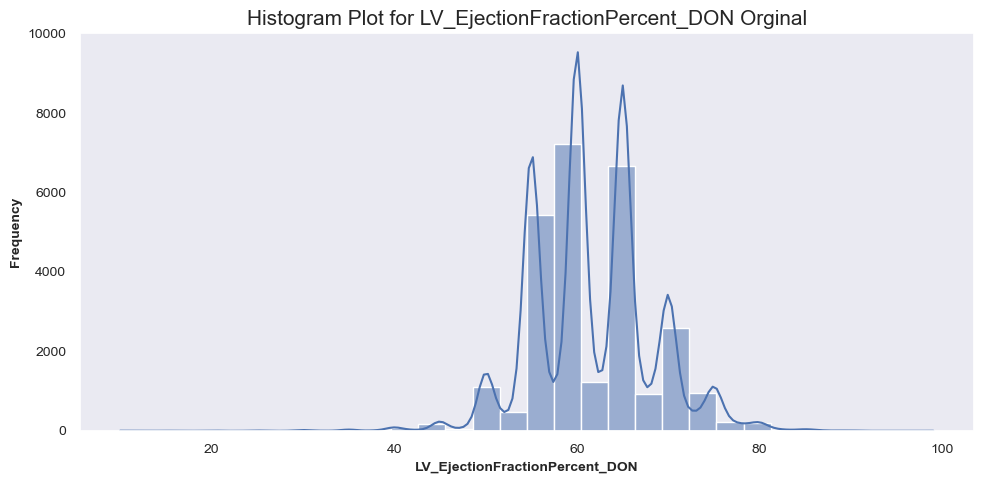

In [92]:
uv.plot_histogram(df_impute, features, txt='Orginal', bins=30)

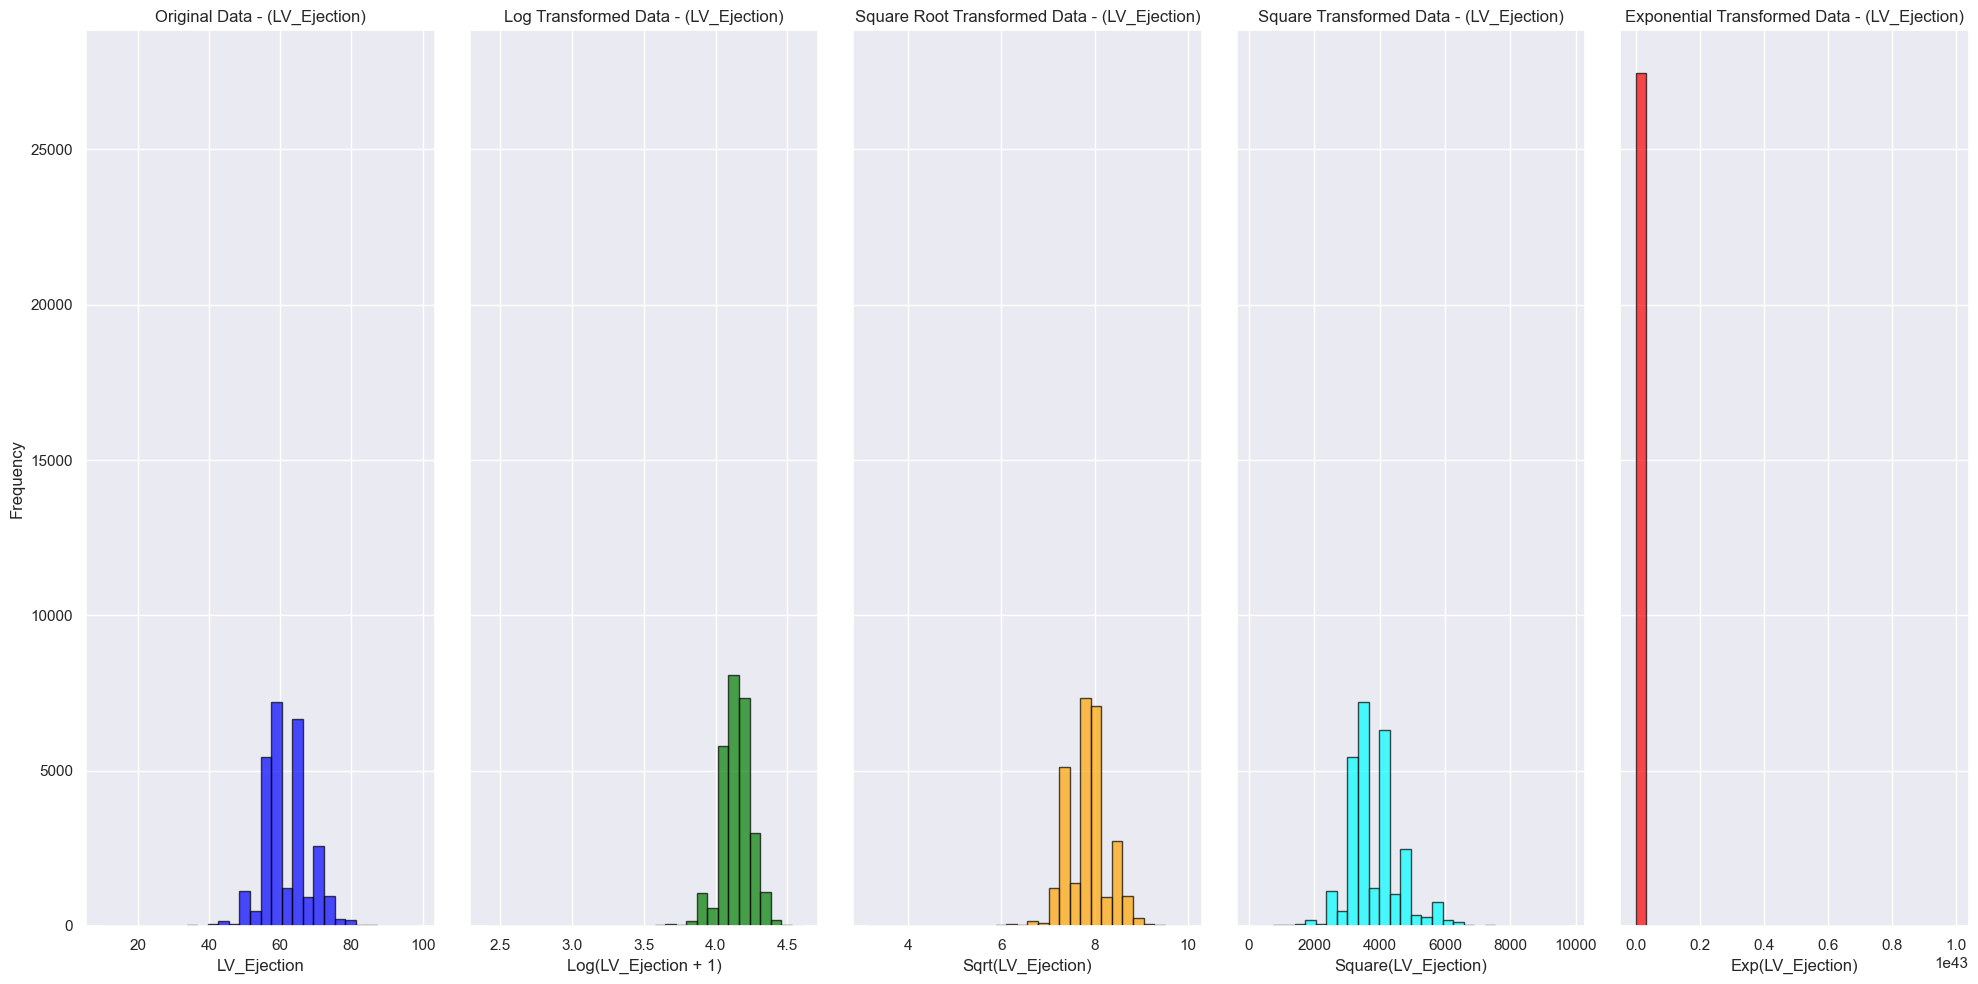

In [93]:
uv.plot_transform_distribution(df_impute[features],txt='LV_Ejection', bins=30)

In [94]:
# impute with median
df_impute[features] = df_impute[features].fillna(df_impute[features].median())
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
LV_EjectionFractionPercent_DON,27494.0,61.61741,6.642224,10.0,56.0,60.0,65.0,99.0


#### Weight

In [95]:
features = uf.get_feature_list(df_impute, 'WeightKg_CAN|WeightKg_DON')

                count       mean        std   min   25%   50%   75%    max
WeightKg_CAN  27487.0  83.252636  18.099450  29.9  70.3  82.6  95.3  159.1
WeightKg_DON  27490.0  83.497006  19.548529  23.2  70.0  80.7  94.0  198.0

:::: NaN Count:
WeightKg_CAN    7
WeightKg_DON    4


In [96]:
# stats test
usf.test_mcar(df_impute[features])

Little's MCAR test p-value: 0.0000
⚠️ Reject null hypothesis: Data is not Missing Completely At Random (MCAR).


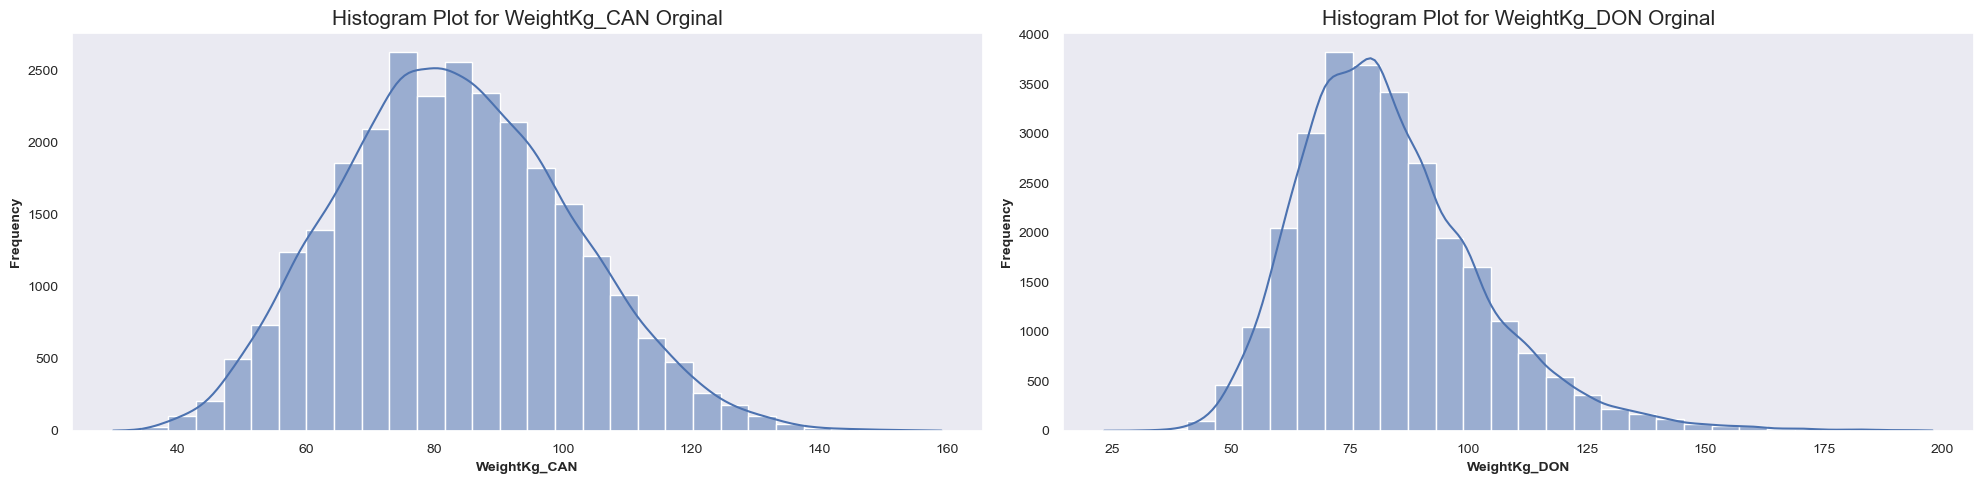

In [97]:
uv.plot_histogram(df_impute, features, txt='Orginal', bins=30)

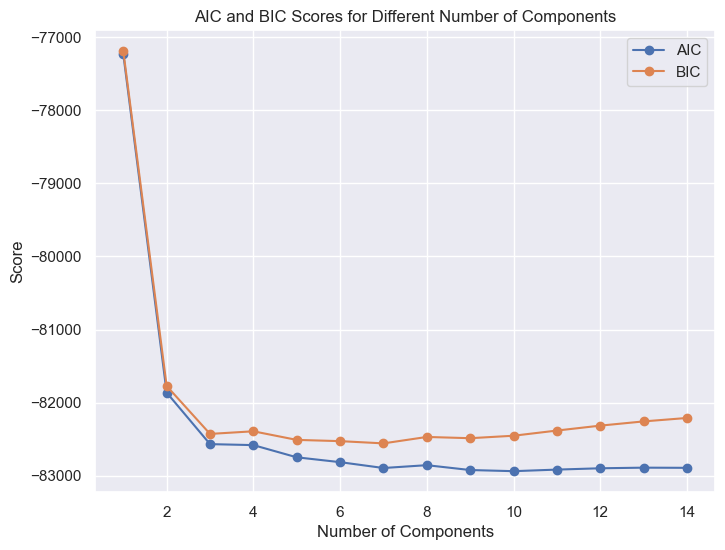

Optimal number of components: 7


In [98]:
# find components
ui.find_gaussian_mixture_components(df_impute[features], component_range=range(1, 15), seed=RANDOM_STATE)

In [99]:
# impute using GMM
imputeGMM = ui.impute_gaussian_mixture(df_impute[features], RANDOM_STATE, n_components=7)

The best n_neighbors for KNN imputer is: 4
The best weights for KNN imputer is: distance


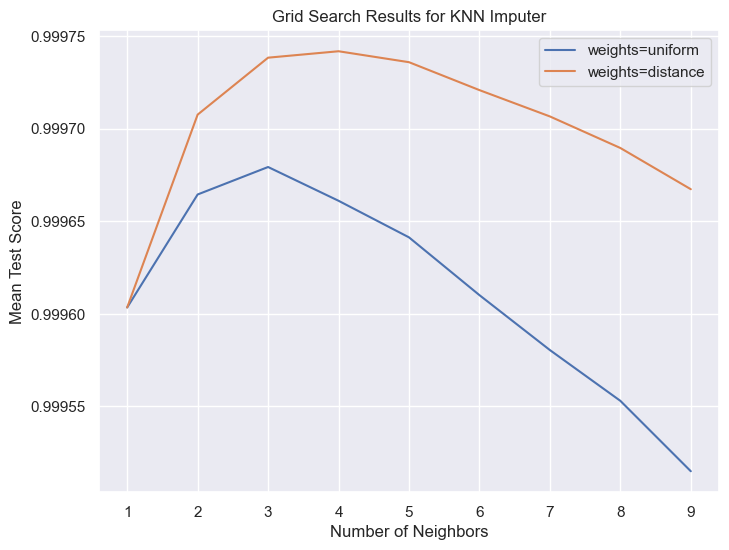

In [100]:
# impute knn
imputeKNN = ui.impute_knn(df_impute[features])

In [101]:
# calculate the average
imputeAverage = (imputeGMM + imputeKNN) / 2

# update imputed features
df_impute[features] = imputeAverage
# display
df_impute[features].describe().T

,count,mean,std,min,25%,50%,75%,max
WeightKg_CAN,27494.0,83.249409,18.098496,29.9,70.3,82.6,95.3,159.1
WeightKg_DON,27494.0,83.497485,19.547446,23.2,70.0,80.7,94.0,198.0


In [102]:
# re-calc feature
df_impute['WeightKg_Addition'] = df_impute.WeightKg_CAN + df_impute.WeightKg_DON

In [103]:
features = uf.get_feature_list(df_impute, 'WeightKg')

                     count        mean        std   min    25%    50%    75%    max
WeightKg_Addition  27494.0  166.746894  32.307347  72.2  144.0  164.7  187.2  335.6
WeightKg_CAN       27494.0   83.249409  18.098496  29.9   70.3   82.6   95.3  159.1
WeightKg_DON       27494.0   83.497485  19.547446  23.2   70.0   80.7   94.0  198.0

:::: NaN Count:
WeightKg_Addition    0
WeightKg_CAN         0
WeightKg_DON         0


In [104]:
# calc BMI
df_impute['BMI_CAN'] = df_impute.WeightKg_CAN / np.square(df_impute.HeightCm_CAN * 0.01)
df_impute['BMI_DON'] = df_impute.WeightKg_DON / np.square(df_impute.HeightCm_DON * 0.01)

# update feature
df_impute['BMI_Addition'] = df_impute.BMI_CAN + df_impute.BMI_DON

### Update df & df_impute

In [105]:
# remove unwanted features
df, df_dict, df_label, df_can, df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date = uf.house_keeping(df, removeCols, df_dict, df_label, df_can,\
                                                                df_don, df_both, df_ordinal, df_nominal, df_numeric, df_drop, df_object, df_unknown, df_date, txt=REMOVE, display=True)

Data Dictionary Updated.
Remove 0 row(s) from df_label DataFrame.
Remove 0 row(s) from df_can DataFrame.
Remove 3 row(s) from df_don DataFrame.
Remove 0 row(s) from df_both DataFrame.
Remove 0 row(s) from df_ordinal DataFrame.
Remove 1 row(s) from df_nominal DataFrame.
Remove 2 row(s) from df_numeric DataFrame.
Remove 0 row(s) from df_drop DataFrame.
Remove 0 row(s) from df_object DataFrame.
Remove 0 row(s) from df_unknown DataFrame.
Remove 0 row(s) from df_date DataFrame.

Removed Features: ['LungPO2_DON', 'LungPO2_Done_DON', 'LungPO2_FIO2_DON']

Total Row(s) & Column(s) Before Removing Column(s): 27,494 & columns: 224
Total Row(s) & Column(s) After Removing Column(s): 27,494 & columns: 221


#### Examine NaNs: Full Dataset (df_impute)

In [106]:
# get NaNs
NaNsDF = uf.percentage_null(df_impute)

# display NaNs
NaNsDF

,percentage,NaNCount
LengthOfStay,3.226158,887
TransplantSurvivalDay,1.545792,425
LungPO2_FIO2_DON,1.160253,319
LungPO2_DON,0.872918,240


In [107]:
# remove unused categories
df = uf.remove_cat_zero_count(df).copy()
df_impute = uf.remove_cat_zero_count(df_impute).copy()

### Save

In [108]:
# heart dataset
uf.write_to_file(df, '5Heart_ML_Orig',path='../Data/', format='pkl')

# heart dataset
uf.write_to_file(df_impute, '5Heart_ML_Impute',path='../Data/', format='pkl')

# heart label
uf.write_to_file(df_label, '5Label_ML',path='../Data/', format='pkl')

# heart candidate
uf.write_to_file(df_can, '5CAN_ML', format='pkl')

# heart donor
uf.write_to_file(df_don, '5DON_ML', format='pkl')

# heart both
uf.write_to_file(df_both, '5BOTH_ML', format='pkl')

# heart nominal
uf.write_to_file(df_nominal, '5Nominal_ML', format='pkl')

# heart ordinal
uf.write_to_file(df_ordinal, '5Ordinal_ML', format='pkl')

# heart numeric
uf.write_to_file(df_numeric, '5Numeric_ML', format='pkl')

# heart drop
uf.write_to_file(df_drop, '5Drop_ML', format='pkl')

# heart new
uf.write_to_file(df_new, '5New_ML', format='pkl')

# heart object
uf.write_to_file(df_object, '5Object_ML', format='pkl')

# heart unknown
uf.write_to_file(df_unknown, '5Unknown_ML', format='pkl')

# heart date
uf.write_to_file(df_date, '5Date_ML', format='pkl')

# heart data dictionary
uf.write_to_file(df_dict, '5Dictionary_ML', format='pkl')

27,494 records written to ../Data/5Heart_ML_Orig.pkl
27,494 records written to ../Data/5Heart_ML_Impute.pkl
2 records written to ../Data/5Label_ML.pkl
119 records written to ../Data/5CAN_ML.pkl
86 records written to ../Data/5DON_ML.pkl
15 records written to ../Data/5BOTH_ML.pkl
166 records written to ../Data/5Nominal_ML.pkl
11 records written to ../Data/5Ordinal_ML.pkl
45 records written to ../Data/5Numeric_ML.pkl
26 records written to ../Data/5Drop_ML.pkl
9 records written to ../Data/5New_ML.pkl
0 records written to ../Data/5Object_ML.pkl
0 records written to ../Data/5Unknown_ML.pkl
0 records written to ../Data/5Date_ML.pkl
302 records written to ../Data/5Dictionary_ML.pkl
